# File

This file will contain only plots that are planned for the final paper, so that we have everything organized

This will follow the google doc created for paper outline

In [1]:
from classification import diversity_barchart, diversity_dotplot, \
                            plot_intermediate_characteristics
import cfg
from ip3_ca_ode_cfg import plot_bifurcation, run_experiment, plot_experiment_plots, set_init, \
                            save_experiment, load_experiment
from falloff import capture_c, report_max_ratios
from spritz_diagram import run_spritz

import pickle
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy
import scipy.integrate


diversity_data_folder = 'data/ca_diversity/calibrated/'
diversity_fig_folder = 'figures/paper_plots/diversity/'
falloff_fig_folder = 'figures/paper_plots/falloff/'
spritz_fig_folder = 'figures/paper_plots/spritz/'
model_fig_folder = 'figures/paper_plots/modeling/'

In [ ]:
#optional - run this to make text larger
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

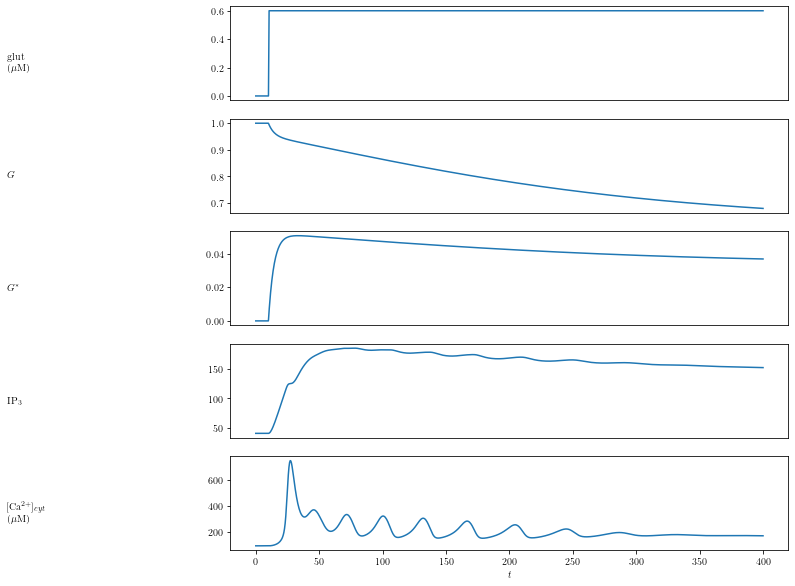

In [12]:
cfg.input_duration = 400
cfg.input_max = 0.6
run_experiment('pulse', t_f=400)
plot_experiment_plots(['glut', 'G', 'Gstar', 'p', 'c'])

# Modeling

This section demonstrates some examples of behaviors that the full system is able to produce. Many parameters were calibrated on these input protocols so that they would act as desired on these tasks (oscillations at specific glutamate concentration ranges, amplitude decay on oscillations, plateau shapes, skipping behavior in spritz, desensitization of response on double bath protocol)

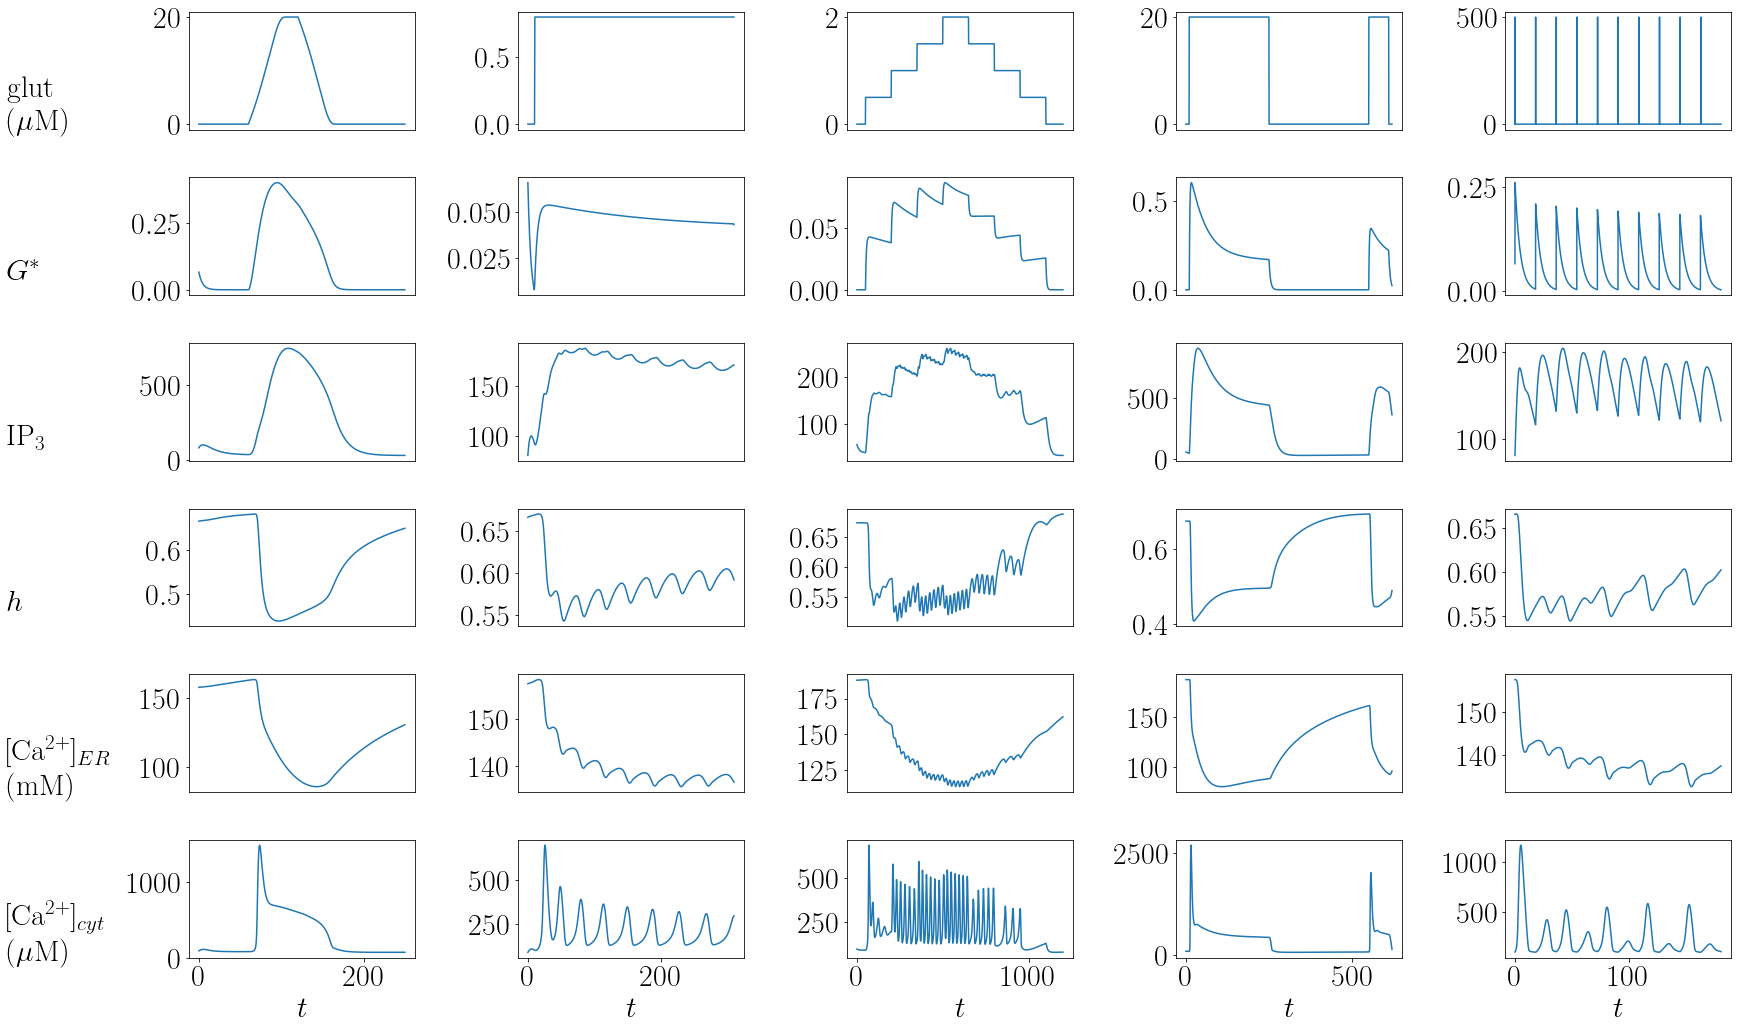

In [3]:
#Plot different experiments to show the validity of different regimes behavior
fig, ax = plt.subplots(6, 5, figsize=(25, 15))

# Plateau response (20-50uM)
set_init('poisson')
cfg.input_max = 20
cfg.input_start = 60
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

run_experiment('exponential_pulse', t_f=250, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], axs=ax[:, 0], ylabel_padding=[-0.8, 0.2])

# Oscillatory response (1-10uM)
set_init('poisson')
cfg.input_max = 0.8 #r_5p=0.08
# cfg.input_max = 2 #r_5p=1.2
cfg.input_start = 10
cfg.input_duration = 300

run_experiment('pulse', t_f=310, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], axs=ax[:, 1], add_ylabels=False)

# Stepped oscillatory response
set_init('default')
cfg.step_max_value = 2 #r_5p = 0.08
# cfg.step_max_value = 3 #r_5p = 0.12
run_experiment('step', t_f=1200, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], axs=ax[:, 2], add_ylabels=False)

# Double bath
cfg.custom_input_vals = [0, 20, 0, 20, 0]
bath_len = 240
rest = 300
ratio_times = [10, 10+bath_len, 10+bath_len+rest, 70+bath_len+rest]
cfg.custom_input_times = [0] + ratio_times
run_experiment('custom', t_f=80+bath_len+rest, max_step=0.5)
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], axs=ax[:, 3], add_ylabels=False)

# Spritz
set_init('poisson')
run_spritz(period=18, conc=500, dur=0.06) #r_5p = 0.08
# run_spritz(period=12, conc=500, dur=0.06) #r_5p = 0.12
plot_experiment_plots(['glut', 'Gstar', 'p', 'h', 'c_er', 'c'], axs=ax[:, 4], add_ylabels=False)

plt.tight_layout()
plt.savefig(model_fig_folder + 'full_model_examples.png', bbox_inches='tight')

set_init('default')

## Double Bath

This experiment was used to calibrate Gd1 and Gd2 strength. Based on information from Marsa, we expected there to be some effects of short-term desensitization (Gd1, homologous GPCR desensitization) which are mostly recovered within a few minutes, but long-term (Gd2, heterologous GPCR desensitization) which still persists after 10 minutes.

In [7]:
'''
Double bath data collection for rest time summary subplot
'''

# first_ons = np.arange(10, 620, 100)
first = 240
# gluts = np.arange(0.1, 1, 0.2)
glut = 20
slider = [0, 0.5, 1]
rests = np.arange(10, 620, 20)
cmap = matplotlib.cm.get_cmap('coolwarm')
# fig, ax = plt.subplots(1, len(first_ons), figsize=(21, 4), sharey=True)
kd1 = cfg.kd1
kd2 = cfg.kd2
for i, mod in enumerate(tqdm(slider)):
    ratios = []
    color = cmap(mod) if mod != 0.5 else 'k'
    
    cfg.kd1 = kd1 * mod
    cfg.kd2 = kd2 * (1 - mod)
    for rest in rests:

        experiment_name = 'bath_{}_rest_{}_mod_{}'.format(first, rest, round(mod, 1))
        file_name = 'double_bath/' + experiment_name
#             if not experiment_name in os.listdir('data/experiments/double_bath'):

        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
        cfg.custom_input_times = [0, 10, 10+first, 10+first+rest, 70+first+rest]
        cfg.custom_input_vals = [0, glut, 0, glut, 0]

        sol = run_experiment('custom', t_f=80+first+rest, max_step=0.2)
        save_experiment(file_name, verbose=False)

        ratio, _, _ = report_max_ratios(times=ratio_times)
        ratios.append(ratio)


cfg.kd1 = kd1
cfg.kd2 = kd2

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:24<00:00, 28.30s/it]


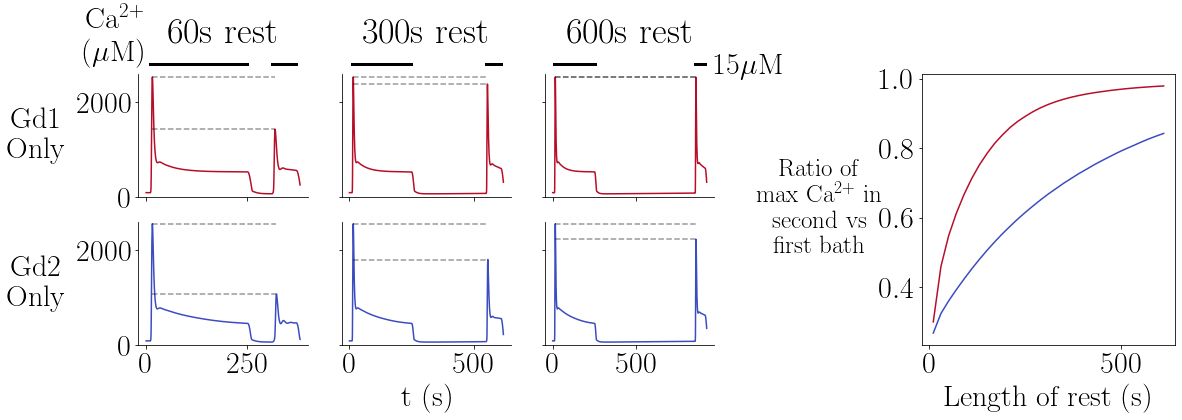

In [5]:
rests = [60, 300, 600]
cfg.custom_input_vals = [0, 15, 0, 15, 0]
kd1 = 0.02
kd2 = 1.2
set_init('default')
first = 240
fig = plt.figure(constrained_layout=False, figsize=(16, 5))
gs = fig.add_gridspec(nrows=2, ncols=3, left=0, right=0.5)
gs2 = fig.add_gridspec(1, 1, left=0.68)
ax = []
for i in range(2):
    ax.append([])
    for j in range(3):
        sharex = ax[0][j] if i > 0 else None #share col x
        sharey = ax[i][0] if j > 0 else None #share row y
        ax[i].append(fig.add_subplot(gs[i, j], sharex=sharex, sharey=sharey))
ax = np.array(ax)


cmap = matplotlib.cm.get_cmap('coolwarm')
blue = cmap(0)
red = cmap(0.99)

for i, rest in enumerate(rests):    
    ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
    cfg.custom_input_times = [0] + ratio_times
    
    cfg.kd1 = kd1
    cfg.kd2 = 0
    run_experiment('custom', t_f=80+first+rest, max_step=0.5)
    ax[0, i].plot(cfg.t, cfg.c * 1000, c=red)
    _, maxes, pos = report_max_ratios(ratio_times)
    ax[0, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[0]*1000, maxes[0]*1000], '--k', alpha=0.4)
    ax[0, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[1]*1000, maxes[1]*1000], '--k', alpha=0.4)
    
    cfg.kd1 = 0
    cfg.kd2 = kd2
    run_experiment('custom', t_f=80+first+rest, max_step=0.5)
    _, maxes, pos = report_max_ratios(ratio_times)
    ax[1, i].plot(cfg.t, cfg.c * 1000, c=blue)
    ax[1, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[0]*1000, maxes[0]*1000], '--k', alpha=0.4)
    ax[1, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[1]*1000, maxes[1]*1000], '--k', alpha=0.4)
    
    ax[0, i].plot([ratio_times[0], ratio_times[1]], [2800, 2800], 'k', linewidth=3, clip_on=False)
    ax[0, i].plot([ratio_times[2], ratio_times[3]], [2800, 2800], 'k', linewidth=3, clip_on=False)

    ax[0, i].spines['top'].set_visible(False)
    ax[0, i].spines['right'].set_visible(False)
    ax[1, i].spines['top'].set_visible(False)
    ax[1, i].spines['right'].set_visible(False)
    
    ax[0, i].set_title('{}s rest'.format(rest), pad=30)
    
    if i > 0:
        plt.setp(ax[0, i].get_yticklabels(), visible=False)
        plt.setp(ax[1, i].get_yticklabels(), visible=False)
#         ax[0, i].set_yticks([])
#         ax[1, i].set_yticks([])
    plt.setp(ax[0, i].get_xticklabels(), visible=False)
cfg.kd1 = kd1
cfg.kd2 = kd2

ax[1, 1].set_xlabel('t (s)')
ax[0, 0].set_ylabel('Gd1 \n Only', rotation=0, ha='center', va='center', labelpad=40)
ax[1, 0].set_ylabel('Gd2 \n Only', rotation=0, ha='center', va='center', labelpad=40)

ax[0, 0].set_ylim([0, 2600])
ax[1, 0].set_ylim([0, 2600])
plt.text(-0.02, 0.98, 'Ca$^{2+}$ \n ($\mu$M)', ha='center', va='center', transform=plt.gcf().transFigure)
# plt.tight_layout()

ax2 = fig.add_subplot(gs2[0])
rests = np.arange(10, 620, 20)
first = 240
# labels = ['Gd1 \']
slider = [0, 1]
for i, mod in enumerate(slider):
    color = cmap(mod - 0.01) if mod != 0.5 else 'k'
    ratios = []

    for rest in rests:
        experiment_name = 'bath_{}_rest_{}_mod_{}'.format(first, rest, round(mod, 1))
        file_name = 'double_bath/' + experiment_name
        load_experiment(file_name, verbose=False)
        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

        ratio, _, _ = report_max_ratios(times=ratio_times)
        ratios.append(ratio)
    ax2.plot(rests, ratios, c=color)
ax2.set_ylabel('Ratio of \n max Ca$^{2+}$ in \n second vs \n first bath', rotation=0, ha='center', va='center', labelpad=60,
              fontsize=25)
ax2.set_xlabel('Length of rest (s)')

plt.text(0.53, 0.9, '15$\mu$M', ha='center', va='center', transform=plt.gcf().transFigure)

plt.savefig(model_fig_folder + 'double_bath_rest_times', bbox_inches='tight')

Text(0.5, 0, 'Length of rest (s)')

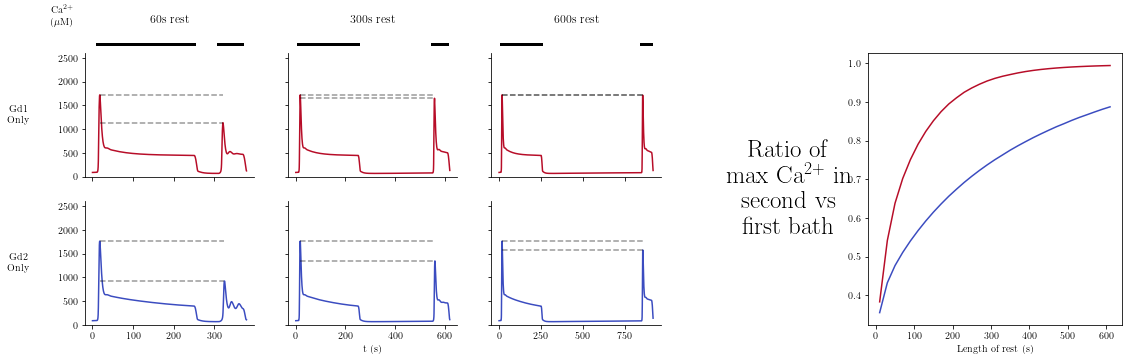

In [12]:
rests = [60, 300, 600]
cfg.custom_input_vals = [0, 15, 0, 15, 0]
kd1 = 0.02
kd2 = 1.2
set_init('default')
first = 240
fig = plt.figure(constrained_layout=False, figsize=(16, 5))
gs = fig.add_gridspec(nrows=2, ncols=3, left=0, right=0.5)
gs2 = fig.add_gridspec(1, 1, left=0.68)
ax = []
for i in range(2):
    ax.append([])
    for j in range(3):
        sharex = ax[0][j] if i > 0 else None #share col x
        sharey = ax[i][0] if j > 0 else None #share row y
        ax[i].append(fig.add_subplot(gs[i, j], sharex=sharex, sharey=sharey))
ax = np.array(ax)


cmap = matplotlib.cm.get_cmap('coolwarm')
blue = cmap(0)
red = cmap(0.99)

for i, rest in enumerate(rests):    
    ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]
    cfg.custom_input_times = [0] + ratio_times
    
    cfg.kd1 = kd1
    cfg.kd2 = 0
    run_experiment('custom', t_f=80+first+rest, max_step=0.5)
    ax[0, i].plot(cfg.t, cfg.c * 1000, c=red)
    _, maxes, pos = report_max_ratios(ratio_times)
    ax[0, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[0]*1000, maxes[0]*1000], '--k', alpha=0.4)
    ax[0, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[1]*1000, maxes[1]*1000], '--k', alpha=0.4)
    
    cfg.kd1 = 0
    cfg.kd2 = kd2
    run_experiment('custom', t_f=80+first+rest, max_step=0.5)
    _, maxes, pos = report_max_ratios(ratio_times)
    ax[1, i].plot(cfg.t, cfg.c * 1000, c=blue)
    ax[1, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[0]*1000, maxes[0]*1000], '--k', alpha=0.4)
    ax[1, i].plot([cfg.t[pos[0]], cfg.t[pos[1]]], [maxes[1]*1000, maxes[1]*1000], '--k', alpha=0.4)
    
    ax[0, i].plot([ratio_times[0], ratio_times[1]], [2800, 2800], 'k', linewidth=3, clip_on=False)
    ax[0, i].plot([ratio_times[2], ratio_times[3]], [2800, 2800], 'k', linewidth=3, clip_on=False)

    ax[0, i].spines['top'].set_visible(False)
    ax[0, i].spines['right'].set_visible(False)
    ax[1, i].spines['top'].set_visible(False)
    ax[1, i].spines['right'].set_visible(False)
    
    ax[0, i].set_title('{}s rest'.format(rest), pad=30)
    
    if i > 0:
        plt.setp(ax[0, i].get_yticklabels(), visible=False)
        plt.setp(ax[1, i].get_yticklabels(), visible=False)
#         ax[0, i].set_yticks([])
#         ax[1, i].set_yticks([])
    plt.setp(ax[0, i].get_xticklabels(), visible=False)
cfg.kd1 = kd1
cfg.kd2 = kd2

ax[1, 1].set_xlabel('t (s)')
ax[0, 0].set_ylabel('Gd1 \n Only', rotation=0, ha='center', va='center', labelpad=40)
ax[1, 0].set_ylabel('Gd2 \n Only', rotation=0, ha='center', va='center', labelpad=40)

ax[0, 0].set_ylim([0, 2600])
ax[1, 0].set_ylim([0, 2600])
plt.text(-0.02, 0.98, 'Ca$^{2+}$ \n ($\mu$M)', ha='center', va='center', transform=plt.gcf().transFigure)
# plt.tight_layout()

ax2 = fig.add_subplot(gs2[0])
rests = np.arange(10, 620, 20)
first = 240
# labels = ['Gd1 \']
slider = [0, 1]
for i, mod in enumerate(slider):
    color = cmap(mod - 0.01) if mod != 0.5 else 'k'
    ratios = []

    for rest in rests:
        experiment_name = 'bath_{}_rest_{}_mod_{}'.format(first, rest, round(mod, 1))
        file_name = 'double_bath/' + experiment_name
        load_experiment(file_name, verbose=False)
        ratio_times = [10, 10+first, 10+first+rest, 70+first+rest]

        ratio, _, _ = report_max_ratios(times=ratio_times)
        ratios.append(ratio)
    ax2.plot(rests, ratios, c=color)
ax2.set_ylabel('Ratio of \n max Ca$^{2+}$ in \n second vs \n first bath', rotation=0, ha='center', va='center', labelpad=60,
              fontsize=25)
ax2.set_xlabel('Length of rest (s)')

# plt.text(0.53, 0.9, '15$\mu$M', ha='center', va='center', transform=plt.gcf().transFigure)

# plt.savefig(model_fig_folder + 'double_bath_rest_times', bbox_inches='tight')

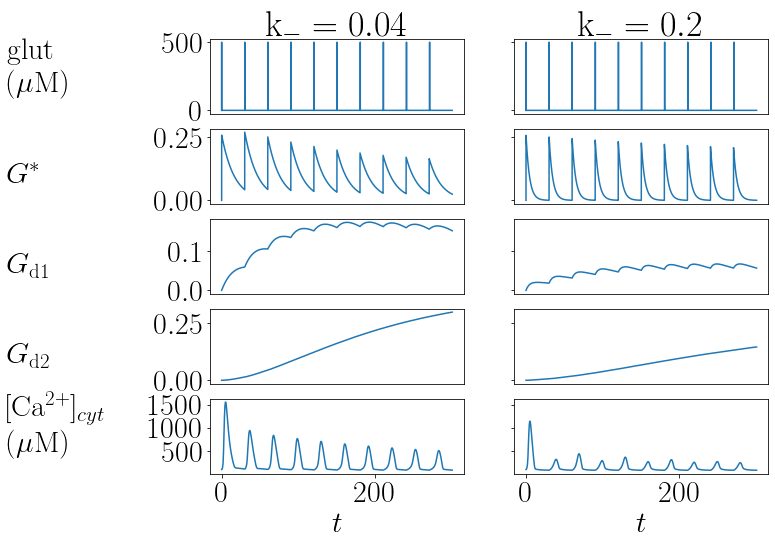

In [4]:
fig, ax = plt.subplots(5, 2, figsize=(10, 8), sharey='row')
cfg.km = 0.04
run_spritz(30, 500, 0.06)
plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'c'], axs=ax[:, 0], ylabel_padding=[-0.8, 0.2])

cfg.km = 0.2
run_spritz(30, 500, 0.06)
plot_experiment_plots(['glut', 'Gstar', 'Gd1', 'Gd2', 'c'], axs=ax[:, 1], add_ylabels=False)

ax[0, 0].set_title('k$_- = 0.04$')
ax[0, 1].set_title('k$_- = 0.2$')

# plt.tight_layout()
plt.savefig(model_fig_folder + 'spritz_km.png', bbox_inches='tight')

# Response Diversity

This section attempts to use a range of glutamate stimulations and determine the distribution of response types in cytosolic calcium transients seen. Prior to running the experiment, we first provide a Poisson spike train input in glutamate to the system to simulate a noisy environment, which brings the distribution more in line with previous paper. This callibration also accounts for the fact that when we change parameters, reasonable steady state conditions will change.

All data collection is handled in **ca_classification3.ipynb**

Uses classification.py functions for plotting

## Calibration Poisson Spikes

Here is the Poisson spike train input used to calibrate the initial condition prior to running diversity experiments. We take the variables at the last time-step of this experiment as a starting point for the simulations. This "warm up" helps to significantly decrease oscillation delays, which allow us to get MP type responses as we expect to see

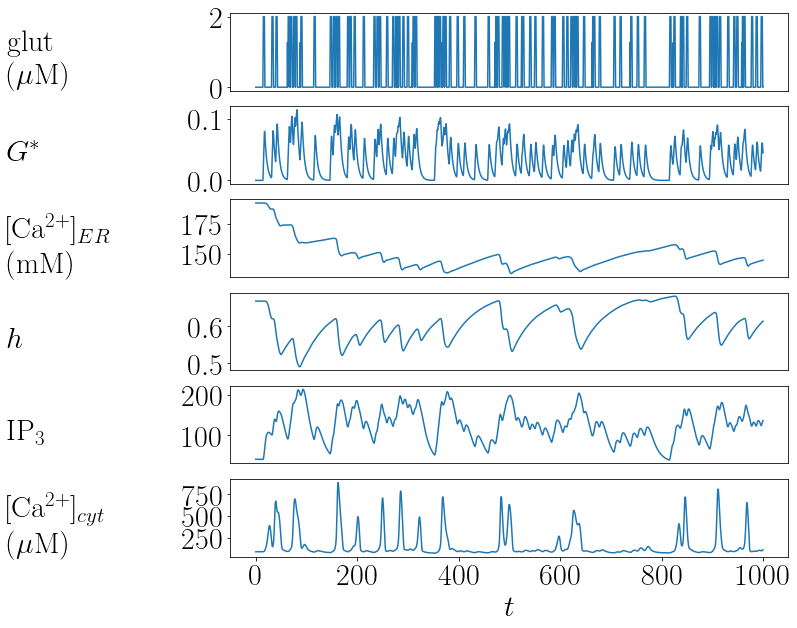

In [9]:
cfg.input_start = 1
cfg.input_smoothing = 1
cfg.input_duration = 2
cfg.input_max = 2
run_experiment('train', max_step=0.5)

plot_experiment_plots(['glut', 'Gstar', 'c_er', 'h', 'p', 'c'])
plt.savefig(diversity_fig_folder + 'poisson_calibration', bbox_inches='tight')

## Generating comparable glutamate stimuli

We tune a range of glutamate stimuli to approximate the range of stimuli used in previous papers (ca_classification2.ipynb)

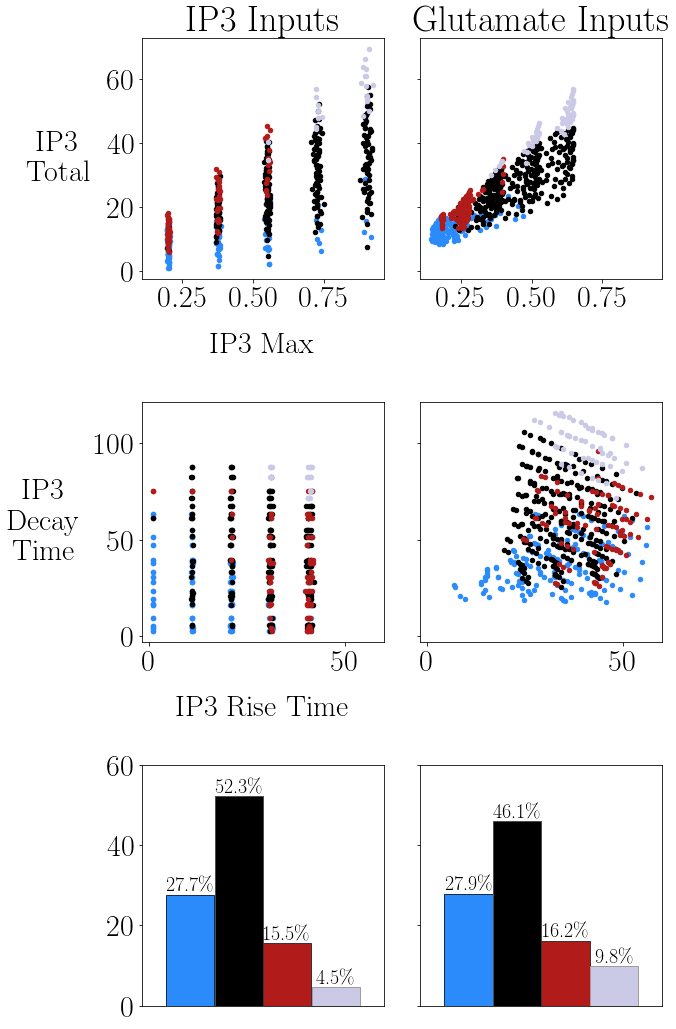

In [10]:
ip3_results = pd.read_pickle('data/ca_diversity/ip3/default')
glut_results = pd.read_pickle('data/ca_diversity/calibrated/kd1_0.02_kd2_1.2_v3k_0.1_vdelta_0.005')
# glut_results = results

fig, ax = plt.subplots(3, 2, figsize=(10, 15), sharey='row', sharex='row')
plot_intermediate_characteristics(ip3_results, ax=ax[0, 0], wiggle=True)
plot_intermediate_characteristics(glut_results, ax=ax[0, 1])
plot_intermediate_characteristics(ip3_results, typ='shape', ax=ax[1, 0], wiggle=True)
plot_intermediate_characteristics(glut_results, typ='shape', ax=ax[1, 1])


ax[0, 0].set_title('IP3 Inputs')
ax[0, 1].set_title('Glutamate Inputs')

ax[0, 0].set_xlabel('IP3 Max', labelpad=20)
ax[0, 0].set_ylabel('IP3 \n Total', rotation=0, labelpad=50, va='center', ha='center')

ax[1, 0].set_xlabel('IP3 Rise Time', labelpad=20)
ax[1, 0].set_ylabel('IP3 \n Decay \n Time', rotation=0, labelpad=50, va='center', ha='center')


diversity_barchart(ip3_results, ax=ax[2, 0], legend=False)
diversity_barchart(glut_results, ax=ax[2, 1], legend=False)

plt.tight_layout()
plt.savefig(diversity_fig_folder + 'ip3_glut_confirmation', bbox_inches='tight')

## Confirmation of channel blocking experiments

Here, we calibrate our set of stimulations and classification algorithm to match the general trends of changing channel parameters to that of the previous paper. The exact proportions are not going to match since we are now using the full model instead of the model starting from IP3 inputs

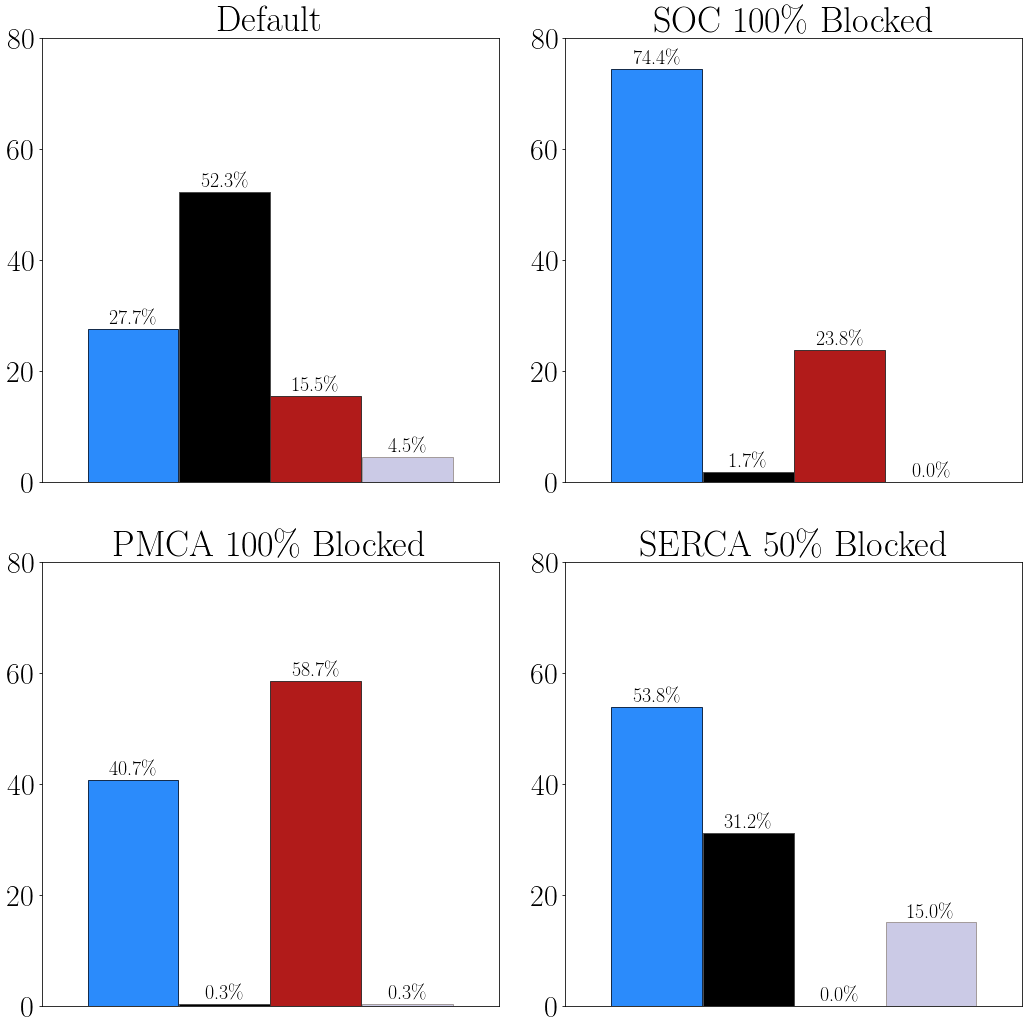

In [18]:
files = ['default', 'soc_0', 'pmca_0', 'serca_0.5']
titles = ['Default', 'SOC 100\% Blocked', 'PMCA 100\% Blocked', 'SERCA 50\% Blocked']

folder = 'data/ca_diversity/blocking/'

fig, ax = plt.subplots(2, 2, figsize=(15, 15))

for i, file in enumerate(files):
    n = i % 2
    m = int(np.floor(i / 2))
    
    results = pd.read_pickle(folder + file)
    diversity_barchart(results, ax=ax[m, n], legend=False, ylim=80)
    
    ax[m, n].set_title(titles[i])
    
plt.tight_layout()
plt.savefig(diversity_fig_folder + 'channel_block_confirmation', bbox_inches='tight')

## Channel Adjustments

We adjust the SOC and SERCA parameters as in the previous paper, this time with glutamate inputs

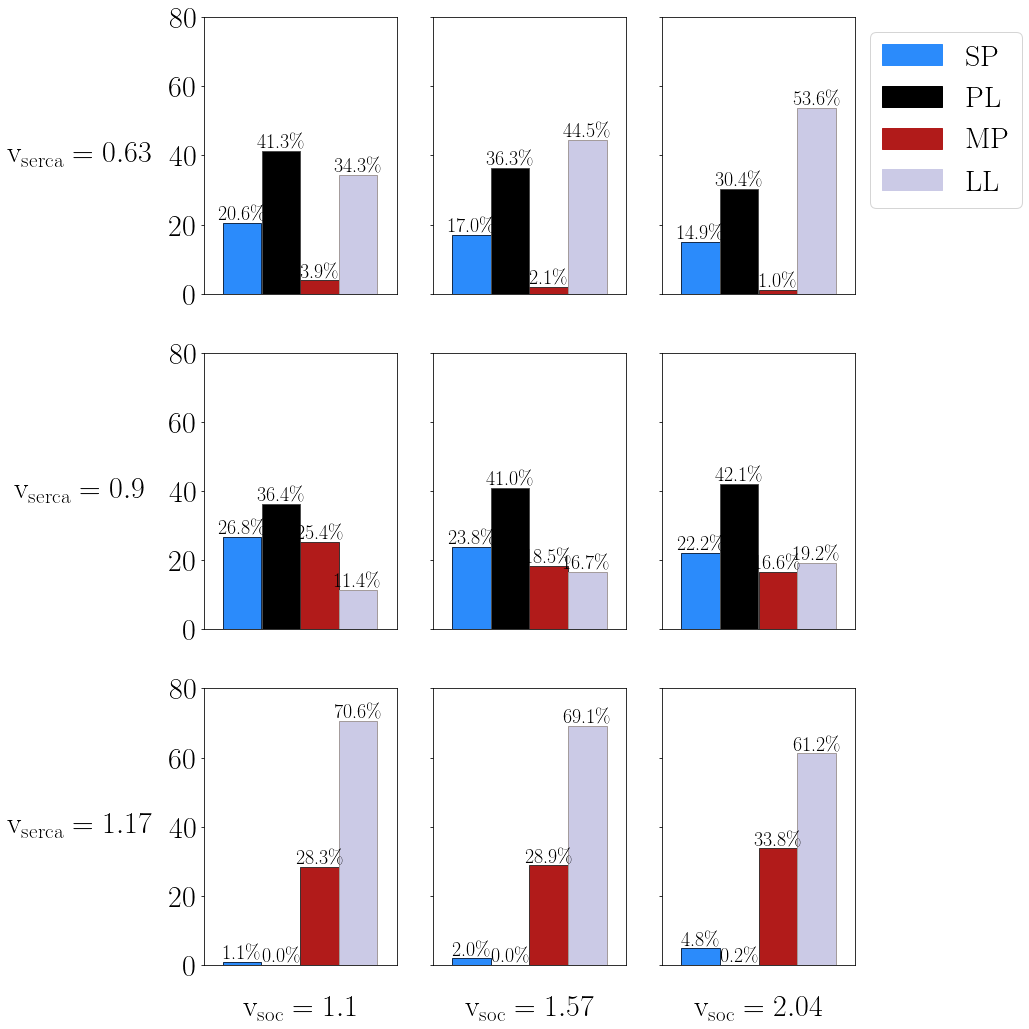

In [12]:
cfg.v_soc = 1.57
cfg.v_serca = 0.9
cfg.v_pmca = 10.0

multipliers = np.array([0.7, 1.0, 1.3])

conditions = {
    'v_serca': multipliers * cfg.v_serca,
    'v_soc': multipliers * cfg.v_soc,
    'v_pmca': multipliers * cfg.v_pmca
}

folder = 'data/ca_diversity/channels/'

#choose fixed conditions - uncomment two of the conditions
fixed = {
#     'v_soc': cfg.v_soc,
#     'v_serca': cfg.v_serca,
    'v_pmca': cfg.v_pmca * multipliers[1],
#     'v_pmca': cfg.v_pmca
}

#partial labels for each parameter type, insert value after and '$' after that to complete label
partial_labels = {
    'v_soc': 'v$_\mathrm{soc}=',
    'v_serca': 'v$_\mathrm{serca}=',
    'v_pmca': 'v$_\mathrm{pmca}=',
}

cond_types = []
for cond in conditions:
    if cond not in fixed:
        cond_types.append(cond)
        
m = len(conditions[cond_types[0]])
n = len(conditions[cond_types[1]])

fig, ax = plt.subplots(m, n, figsize=(n*5, m*5), sharey=True)

for i in range(m):
    for j in range(n):
        for cond in fixed:
            setattr(cfg, cond, fixed[cond])
        
        cond = cond_types[0]
#         setattr(cfg, cond, conditions[cond][m-i-1])
        setattr(cfg, cond, conditions[cond][i])
        cond = cond_types[1]
        setattr(cfg, cond, conditions[cond][j])
        
        file = 'vsoc_{}_vserca_{}_vpmca_{}'.format(cfg.v_soc, cfg.v_serca, cfg.v_pmca)
        
        results = pd.read_pickle(folder + file)
        
        if i == 0 and j == n-1:
            diversity_barchart(results, ax=ax[i, j], legend=True, bbox_to_anchor=(1, 1), loc='upper left', ylim=80)
        else:
            diversity_barchart(results, ax=ax[i, j], legend=False, ylim=80)

for i in range(m):
#     ax[i, 0].set_ylabel(partial_labels[cond_types[0]] + str(round(conditions[cond_types[0]][m-i-1], 2)) + '$', 
#                        rotation=0, ha='center', va='center', labelpad=70)
    ax[i, 0].set_ylabel(partial_labels[cond_types[0]] + str(round(conditions[cond_types[0]][i], 2)) + '$', 
                       rotation=0, ha='center', va='center', labelpad=90)

for j in range(n):
    ax[m-1, j].set_xlabel(partial_labels[cond_types[1]] + str(round(conditions[cond_types[1]][j], 2)) + '$',
                         labelpad=30)
        
plt.tight_layout()

plt.savefig(diversity_fig_folder + 'ip3_param_spread_confirmation', bbox_inches='tight')

cfg.v_soc = 1.57
cfg.v_serca = 0.9
cfg.v_pmca = 10.0

## Testing effects of new parameters
kd1, kd2, v+, v-

Tests run and plots generated in ca_classification3.ipynb

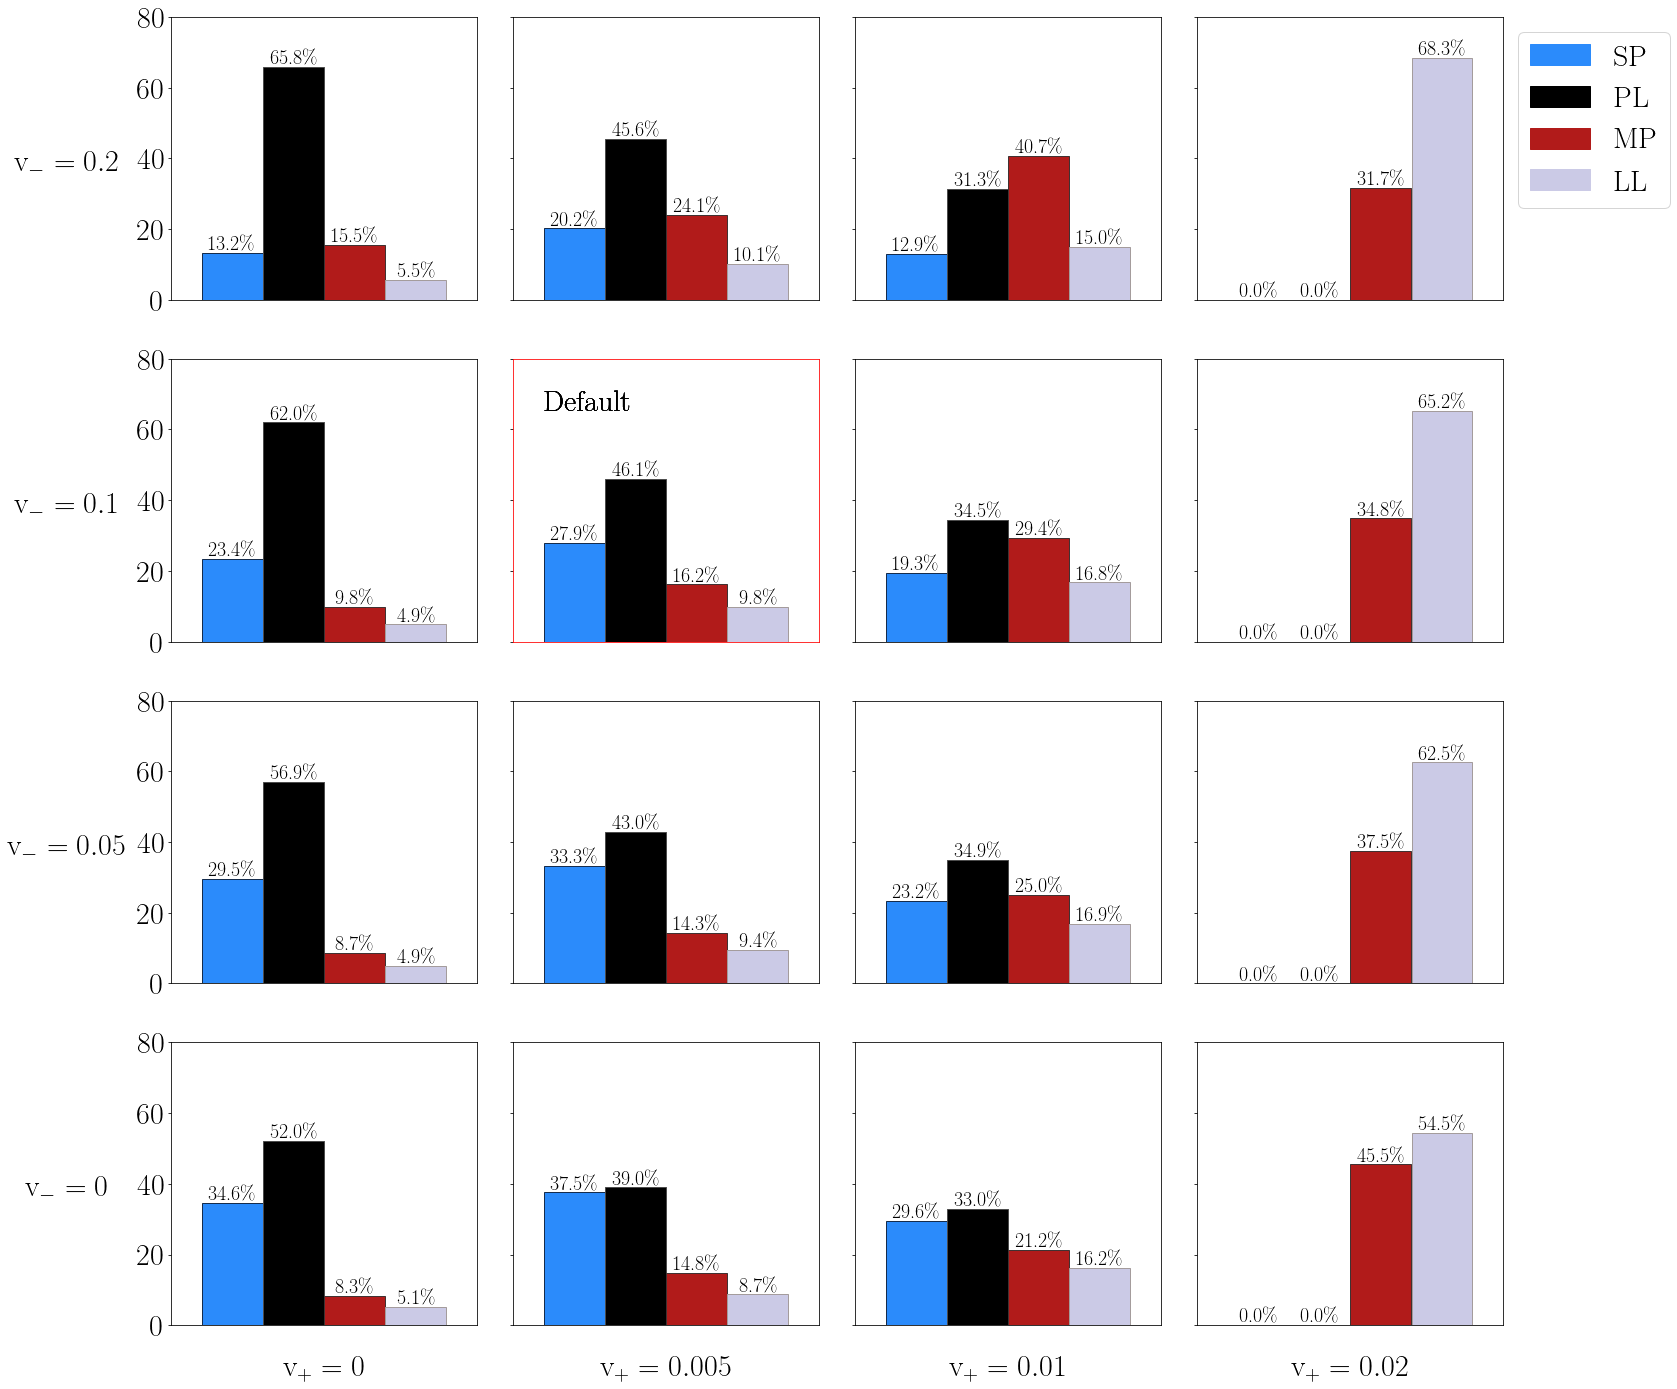

In [13]:
v3ks = [0, 0.05, 0.1, 0.2]
vdeltas = [0, 0.005, 0.01, 0.02] 
kd1 = 0.02
kd2 = 1.2

m = len(v3ks)
n = len(vdeltas)

partial_labels = {
    'kd1': 'k$_{d1}=',
    'kd2': 'k$_{d2}=',
    'v_3k': 'v$_-=',
    'v_delta': 'v$_+=',
}

fig, ax = plt.subplots(m, n, figsize=(n*6, m*5), sharey=True)

for i in range(4):
    for j in range(4):
        file = f'kd1_{kd1}_kd2_{kd2}_v3k_{v3ks[3-i]}_vdelta_{vdeltas[j]}'
        results = pd.read_pickle(diversity_data_folder + file)
        
        if i == 0 and j == n-1:
            diversity_barchart(results, ax=ax[i, j], legend=True, bbox_to_anchor=(1, 1), loc='upper left', ylim=80)
        else:
            diversity_barchart(results, ax=ax[i, j], legend=False, ylim=80)
            
for i in range(m):
    ax[i, 0].set_ylabel(partial_labels['v_3k'] + str(v3ks[m-i-1]) + '$', 
                       rotation=0, ha='center', va='center', labelpad=70)
for j in range(n):
    ax[m-1, j].set_xlabel(partial_labels['v_delta'] + str(vdeltas[j]) + '$',
                         labelpad=30)
        
spines = ['top', 'bottom', 'left', 'right']
for spine in spines:
    ax[1, 1].spines[spine].set_color('red')
    ax[1, 1].text(-0.5, 65, 'Default', size=30)

plt.tight_layout()
plt.savefig(diversity_fig_folder + 'feedback_effects', bbox_inches='tight')

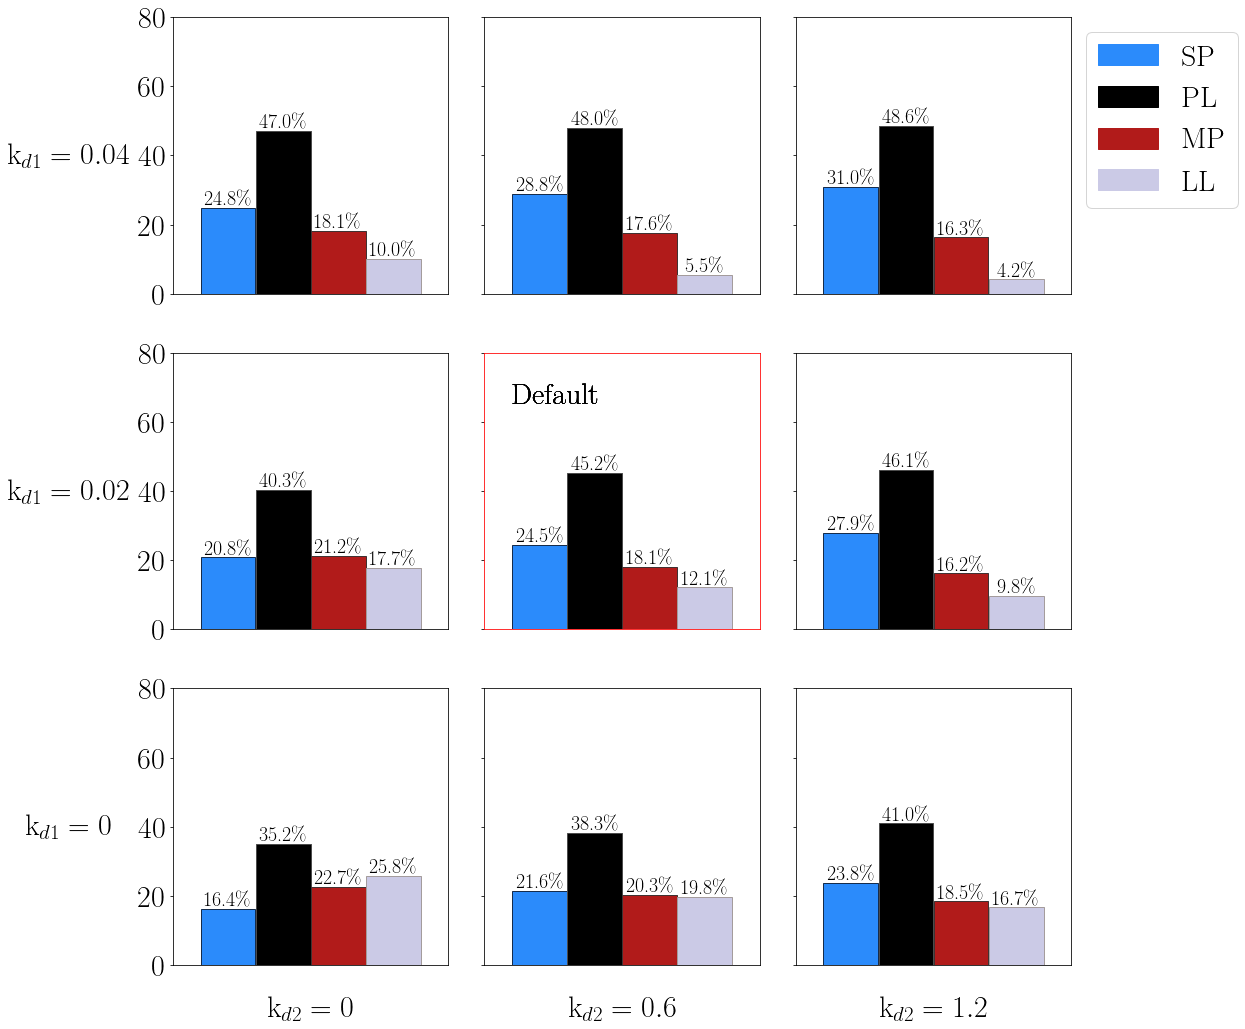

In [14]:
v3k = 0.1
vdelta = 0.005
kd1s = [0, 0.02, 0.04]
kd2s = [0, 0.6, 1.2]

m = len(kd1s)
n = len(kd2s)

partial_labels = {
    'kd1': 'k$_{d1}=',
    'kd2': 'k$_{d2}=',
    'v_3k': 'v$_-=',
    'v_delta': 'v$_+=',
}

fig, ax = plt.subplots(m, n, figsize=(n*6, m*5), sharey=True)

for i in range(3):
    for j in range(3):
        file = f'kd1_{kd1s[2-i]}_kd2_{kd2s[j]}_v3k_{v3k}_vdelta_{vdelta}'
        results = pd.read_pickle(diversity_data_folder + file)
        
        if i == 0 and j == n-1:
            diversity_barchart(results, ax=ax[i, j], legend=True, bbox_to_anchor=(1, 1), loc='upper left', ylim=80)
        else:
            diversity_barchart(results, ax=ax[i, j], legend=False, ylim=80)
            
for i in range(m):
    ax[i, 0].set_ylabel(partial_labels['kd1'] + str(kd1s[m-i-1]) + '$', 
                       rotation=0, ha='center', va='center', labelpad=70)
for j in range(n):
    ax[m-1, j].set_xlabel(partial_labels['kd2'] + str(kd2s[j]) + '$',
                         labelpad=30)
        
spines = ['top', 'bottom', 'left', 'right']
for spine in spines:
    ax[1, 1].spines[spine].set_color('red')
    ax[1, 1].text(-0.5, 65, 'Default', size=30)

plt.tight_layout()
plt.savefig(diversity_fig_folder + 'desensitization_effects', bbox_inches='tight')

## Bifurcation Analysis

The only clear effect shown by bifurcation analysis is the increase in multi-peak and long-lasting responses as v_+ is strengthened

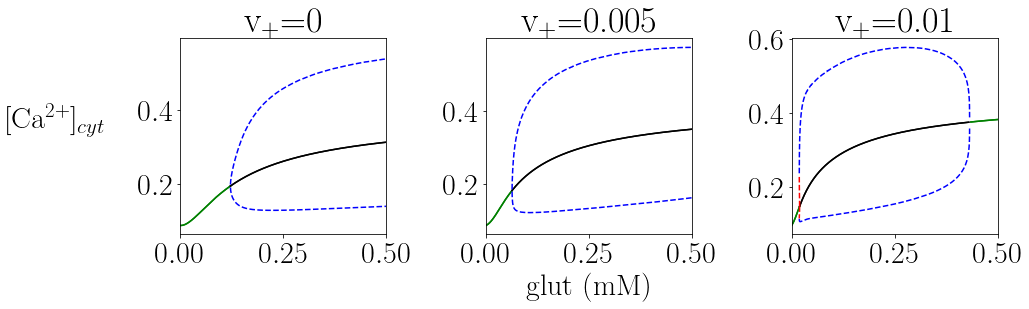

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
vdeltas = [0, 0.005, 0.01]

for i, vdelta in enumerate(vdeltas):
    file = f'c_glut_v3k_0.1_vdelta_{vdelta}.dat'
    plot_bifurcation(file, ax=ax[i])
    ax[i].set_xlim([0, 0.5])
    ax[i].set_title(f'v$_+$={vdelta}')
    
ax[1].set_xlabel('glut (mM)')
ax[0].set_ylabel('[Ca$^{2+}$]$_{cyt}$', rotation=0, labelpad=80)
plt.tight_layout()
plt.savefig('figures/paper_plots/diversity/6_vdelta_bifurcations.png', bbox_inches='tight')

# Calcium Response Falloff

Next, we explore explanations for why calcium responses fall off over time. Most importantly, we attempt to compare the important of GPCR desensitization against that of ER calcium storage depletion over time in weakening calcium responses

## Plateau Responses

Often seen in experiments is an initial spike followed by elevated calcium levels before gradually falling off. We term this a plateau response.

First, we generate a ramped glutamate response which is leads to natural calcium falloff similar to that seen in experimental recordings. This stimulation on the right will be used throughout the section

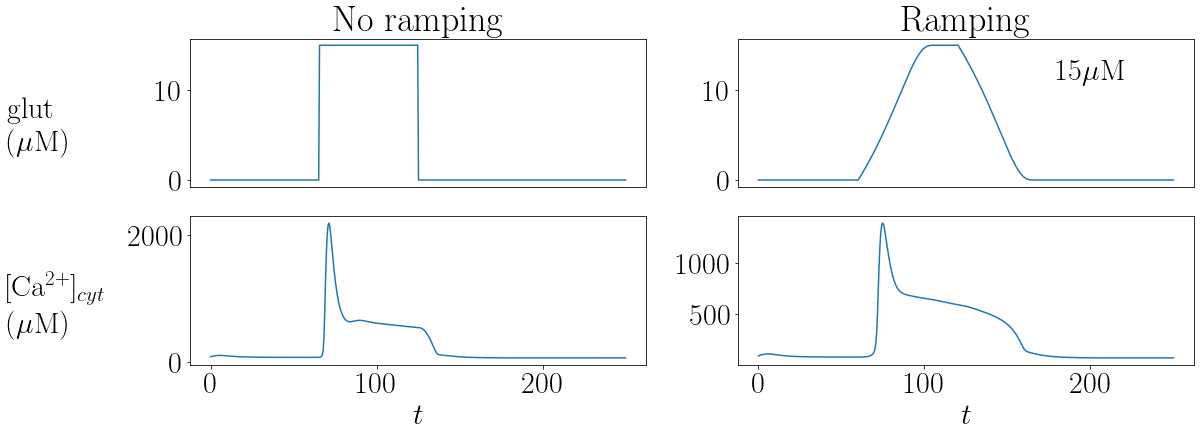

In [10]:
cfg.input_max = 15
cfg.input_start = 65
cfg.input_duration = 60
t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30

run_experiment('pulse', t_f=250, max_step=0.5)

fig, ax = plt.subplots(2, 2, figsize=(18, 6))
plot_experiment_plots(['glut', 'c'], axs=ax[:, 0])

# ax[1, 0].plot(falloff1[0], falloff1[1] * 2 * 1000)

cfg.input_start = 60
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

run_experiment('exponential_pulse', t_f=250, max_step=0.5)

plot_experiment_plots(['glut', 'c'], axs=ax[:, 1], legend_label='simulation', add_ylabels=False)

# ax[1, 1].plot(falloff1[0], falloff1[1] * 1.2 * 1000, label='data')

# ax[1, 1].legend(bbox_to_anchor=(1, 1, 0, 0))

ax[0, 0].set_title('No ramping')
ax[0, 1].set_title('Ramping')

ax[0, 1].text(200, 12, '15$\mu$M', va='center', ha='center')

plt.savefig(falloff_fig_folder + '1.1_replicate_rampdown.png', bbox_inches='tight')


### ER and Gd1 Manipulation

We identify ER depletion and Gd1 as the main factors contributing to the plateau response weakening over time. We perform the following experimental manipulations

**ER Depletion**
We can artificially "refill" the ER calcium by fixing the ER calcium variable. We can also aritificially increase the depletion rate by recording the ER drain experienced during the control experiment and increasing it. 

**Gd1 Strength**
To manipulate homologous (fast) GPCR depletion, we simply adjust the kd1 parameter.

The black line indicates ramping bath stimulation. The plotted dots indicate two time points between which calcium decay rate will be measured

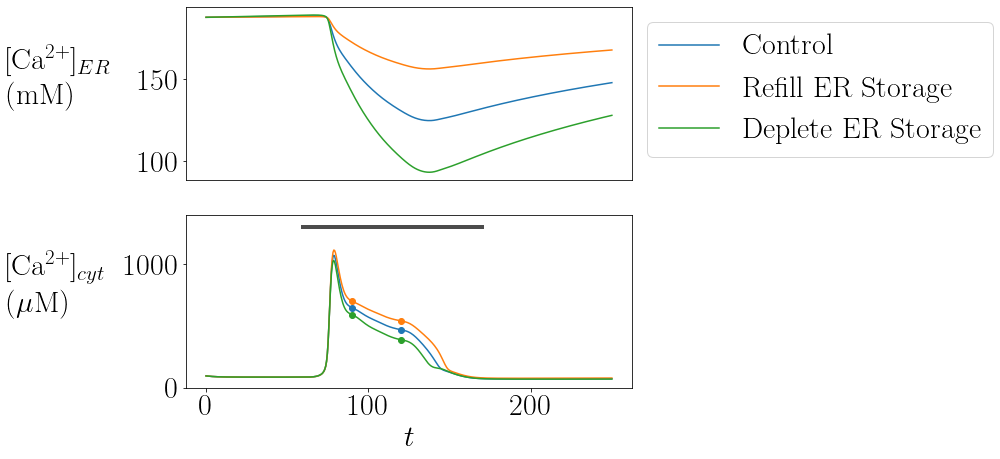

In [49]:
cfg.input_max = 0.2
cfg.input_start = 60
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30


fig, ax = plt.subplots(2, 1, figsize=(8, 7))

run_experiment('exponential_pulse', t_f=250, max_step=0.5)
plot_experiment_plots(['c_er', 'c'], axs=ax, legend_label='Control', plot_input=False)
fix_c_er = cfg.c_er
ax[1].scatter([t1, t2], [capture_c(t1)*1000, capture_c(t2)*1000])

mult = 0.5
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)
plot_experiment_plots(['c_er', 'c'], axs=ax, legend_label='Refill ER Storage', plot_input=False)
ax[1].scatter([t1, t2], [capture_c(t1)*1000, capture_c(t2)*1000])

mult = 1.5
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er_func=inter)
plot_experiment_plots(['c_er', 'c'], axs=ax, legend_label='Deplete ER Storage', plot_input=False)
ax[1].scatter([t1, t2], [capture_c(t1)*1000, capture_c(t2)*1000])

ax[0].legend(bbox_to_anchor=(1, 1, 0, 0))

ax[1].plot([cfg.input_start-cfg.input_smoothing, cfg.input_start + cfg.input_duration + 
            cfg.input_smoothing], [1300, 1300], c='k', linewidth=4, alpha=0.7)
ax[1].set_ylim([0, 1400])
plt.savefig(falloff_fig_folder + '1.3_depletion_example.png', bbox_inches='tight')


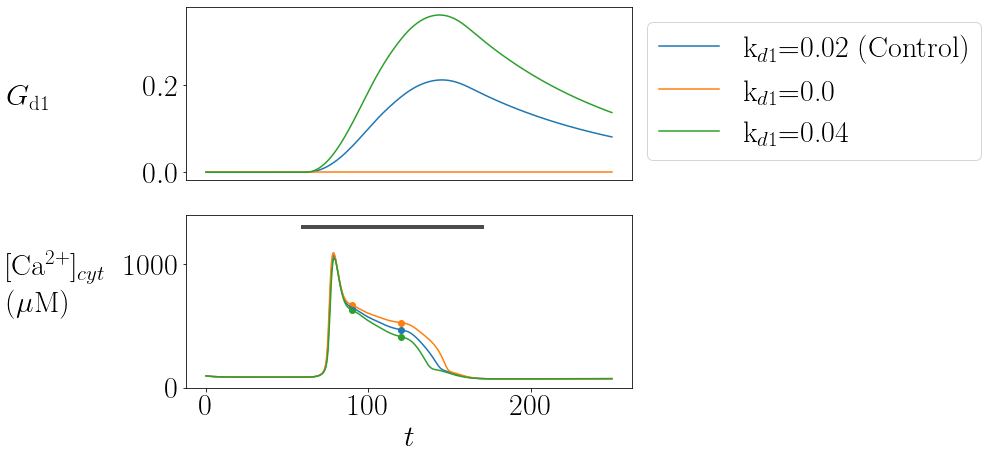

In [50]:
cfg.input_max = 0.2
cfg.input_start = 60
cfg.input_duration = 60
cfg.input_smoothing = 50
cfg.input_start = cfg.input_start + cfg.input_smoothing
cfg.input_duration = cfg.input_duration - cfg.input_smoothing

t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30
kd1 = cfg.kd1

fig, ax = plt.subplots(2, 1, figsize=(8, 7))

run_experiment('exponential_pulse', t_f=250, max_step=0.5)
plot_experiment_plots(['Gd1', 'c'], axs=ax, legend_label='k$_{d1}$='+str(cfg.kd1)+' (Control)', 
                      plot_input=False)
ax[1].scatter([t1, t2], [capture_c(t1)*1000, capture_c(t2)*1000])

mult = 0
cfg.kd1 = kd1 * mult
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=250, max_step=0.5)
plot_experiment_plots(['Gd1', 'c'], axs=ax, legend_label='k$_{d1}$='+str(cfg.kd1), 
                      plot_input=False)
ax[1].scatter([t1, t2], [capture_c(t1)*1000, capture_c(t2)*1000])

mult = 2
cfg.kd1 = kd1 * mult
inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
run_experiment('exponential_pulse', t_f=250, max_step=0.5)
plot_experiment_plots(['Gd1', 'c'], axs=ax, legend_label='k$_{d1}$='+str(cfg.kd1), 
                      plot_input=False)
ax[1].scatter([t1, t2], [capture_c(t1)*1000, capture_c(t2)*1000])

ax[0].legend(bbox_to_anchor=(1, 1, 0, 0))

ax[1].plot([cfg.input_start-cfg.input_smoothing, cfg.input_start + cfg.input_duration + 
            cfg.input_smoothing], [1300, 1300], c='k', linewidth=4, alpha=0.7)
ax[1].set_ylim([0, 1400])
plt.savefig(falloff_fig_folder + '1.3_Gd1_example.png', bbox_inches='tight')

cfg.kd1 = kd1

### Comparisons of calcium decay rate

Here, calcium decay rate is measured as the average change in cytosolic calcium concentration across the two time points shown above. We demonstrate two plots:

1. Fixed stimulation, gradually increasing and decreasing ER depletion or Gd1 strength to show effect on average calcium decay rate.
2. Either no ER depletion (constantly refilled), no Gd1, or neither. We see that with both turned off, there is very little falloff of response strength.

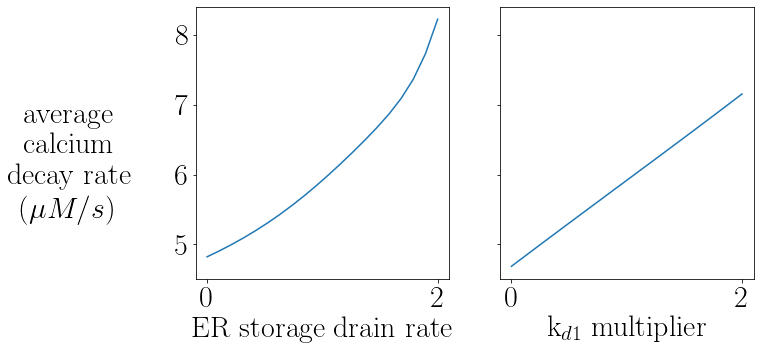

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
multipliers = np.linspace(0, 2, 20)

c1s, c2s, _ = pickle.load(open('data/plot_data/falloff/1.2_plateau_falloff_rate', 'rb'))
c1s2, c2s2, _ = pickle.load(open('data/plot_data/falloff/1.3_plateau_falloff_cer', 'rb'))


ratios = (np.array(c2s2) - np.array(c1s2)) / (t2 - t1)
ax[0].plot(multipliers, -ratios)
ax[0].set_xlabel('ER storage drain rate')
ax[0].set_ylabel('average \n calcium \n decay rate \n ($\mu M / s$)', 
                    rotation=0)
ax[0].get_yaxis().set_label_coords(-0.5, 0.2)

ratios = (np.array(c2s['kd1']) - np.array(c1s['kd1'])) / (t2 - t1)
ax[1].plot(multipliers, -ratios)
ax[1].set_xlabel('k$_{d1}$ multiplier')

plt.savefig(falloff_fig_folder + '1.3_plateau_er_kd1_comparison.png', bbox_inches='tight')

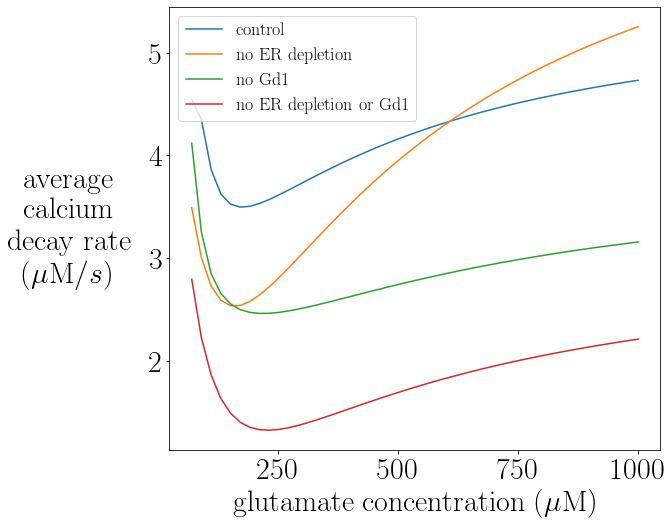

In [57]:
# fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey='row')

gluts = np.linspace(0.01, 1, 50)
t1 = cfg.input_start - cfg.input_smoothing + 30
t2 = t1 + 30
c1s, c2s, areas, maxes, cases = pickle.load(open('data/plot_data/falloff/1.4_on_off_comparison', 'rb'))

plt.figure(figsize=(10, 8))

start_idx = 3

for i, case in enumerate(cases):
    x = i // 2
    y = i % 2
    ratios = (np.array(c2s[case]) - np.array(c1s[case])) / (t2 - t1)
    # ax[x, y].plot(gluts, ratios)
    plt.plot(gluts[start_idx:] * 1000, -ratios[start_idx:], label=case)
    # ax[x, y].set_title(case)

# ax[1, 0].set_ylabel('ratio of \n total c to \n max peak', rotation=0, labelpad=80)
# ax[1, 0].set_xlabel('glutamate concentration')
# plt.ylabel('ratio of \n total c to \n max peak', rotation=0, labelpad=80)
plt.ylabel('average \n calcium \n decay rate \n ($\mu$M$/s$)', rotation=0, labelpad=80, va='center')
plt.xlabel('glutamate concentration ($\mu$M)')

plt.legend(fontsize=18)

plt.tight_layout()

plt.savefig(falloff_fig_folder + '1.4_on_off_rate_comparison.png', bbox_inches='tight')

Note that in these plots, visually we can see that increases to Gd1 strength lead increases to steepness of the plateau falloff, but increases in ER depletion lead to a drop in the mean height of the plateau

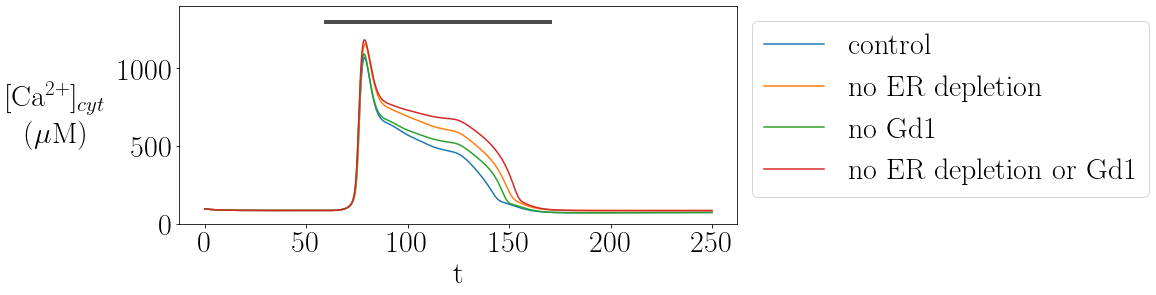

In [73]:
# for glut in tqdm(gluts):
glut = 0.2
cfg.input_max = glut
# fig, axs = plt.subplots(3, 1, figsize=(10, 5))

plt.figure(figsize=(10, 4))
cases = ['control', 'no ER depletion', 'no Gd1', 'no ER depletion or Gd1']
for case in cases:
# for case in ['control', 'no ER depletion', 'no Gd1']:
    # print(case)
    if case == 'control' or case == 'no ER depletion':
        cfg.kd1 = 0.02
    else:
        cfg.kd1 = 0

    if case == 'no ER depletion' or case == 'no ER depletion or Gd1':
        # print('no depletion')
        # print(cfg.kd1)
        run_experiment('exponential_pulse', t_f=250, max_step=0.5, fix_c_er=187.816)
    else:
        run_experiment('exponential_pulse', t_f=250, max_step=0.5)
        
    # plot_experiment_plots(['c_er', 'Gd1', 'c'], axs=axs, legend_label=case, plot_input=False)
    # axs[2].scatter([t1, t2], [capture_c(t1), capture_c(t2)])
    plt.plot(cfg.t, cfg.c*1000, label=case)

plt.plot([60, 170], [1300, 1300], c='k', linewidth=4, alpha=0.7)
plt.ylim([0, 1400])
plt.ylabel('[Ca$^{2+}$]$_{cyt}$ \n ($\mu$M)', labelpad=60, rotation=0, va='center')
plt.xlabel('t')
plt.legend(bbox_to_anchor=(1,1,0,0))

# ax[0].legend(bbox_to_anchor=(1, 1, 0, 0))

plt.savefig(falloff_fig_folder + '1.4_factors_off_example.png', bbox_inches='tight')


## Spike Responses

To observe gradual decay in oscillatory spikes, we need to use a longer response with a weaker glutamate stimulation.

We perform the stimulation for 8 minutes (480 seconds) at a stimulation strength of 80$\mu M$, starting with slightly adjusted initial conditions (drawn from having assumed a prior poisson spike train stimulation at low strength) to decrease oscillation delays and noise in the experiment.

To record response decay, we record the difference in amplitude between the second largest spike and the final spike (marked in red in below plot)

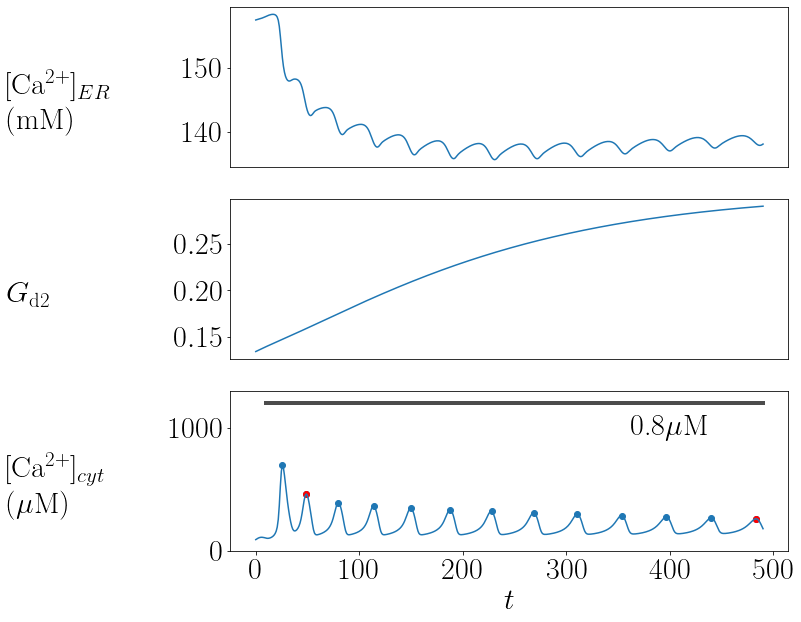

In [9]:
cfg.input_max = 0.8
cfg.input_start = 10
cfg.input_duration = 480
# set_init('default')
# cfg.all_init[1] = cfg.all_init[1] * 0.7
# cfg.all_init[3] = cfg.all_init[3] * 0.7
set_init('poisson')


run_experiment('pulse', t_f=490, max_step=1)
peaks = scipy.signal.find_peaks(cfg.c)[0]
c_peaks = cfg.c[peaks]
max_idx = np.argmax(c_peaks)
peaks = peaks[max_idx:]
second_largest = np.argmax(cfg.c[peaks[1:]]) + 1

# plt.plot(cfg.t, cfg.c)
# plot_experiment_plots(['glut', 'lamb', 'Gstar', 'Gd2', 'c_er', 'c'])
ax = plot_experiment_plots(['c_er', 'Gd2', 'c'], plot_input=False, ret_ax=True)
# plt.plot([0, cfg.t[-1]], [0.2, 0.2])
plt.scatter(cfg.t[peaks], cfg.c[peaks] * 1000)


red_peaks = [peaks[second_largest], peaks[-1]]
plt.scatter(cfg.t[red_peaks], cfg.c[red_peaks] * 1000, c='red')

ax[2].plot([10, 490], [1200, 1200], c='k', alpha=0.7, linewidth=4)
ax[2].set_ylim([0, 1300])

ax[2].text(400, 1000, '0.8$\mu$M', va='center', ha='center')

plt.savefig('figures/paper_plots/falloff/2_2_oscillation_example.png', bbox_inches='tight')


Of the new model parameters, only increases in Gd2 strength are correlated with increased amplitude decay. We compare the effects of Gd2 against the effects of ER depletion in contributing to the decay effect

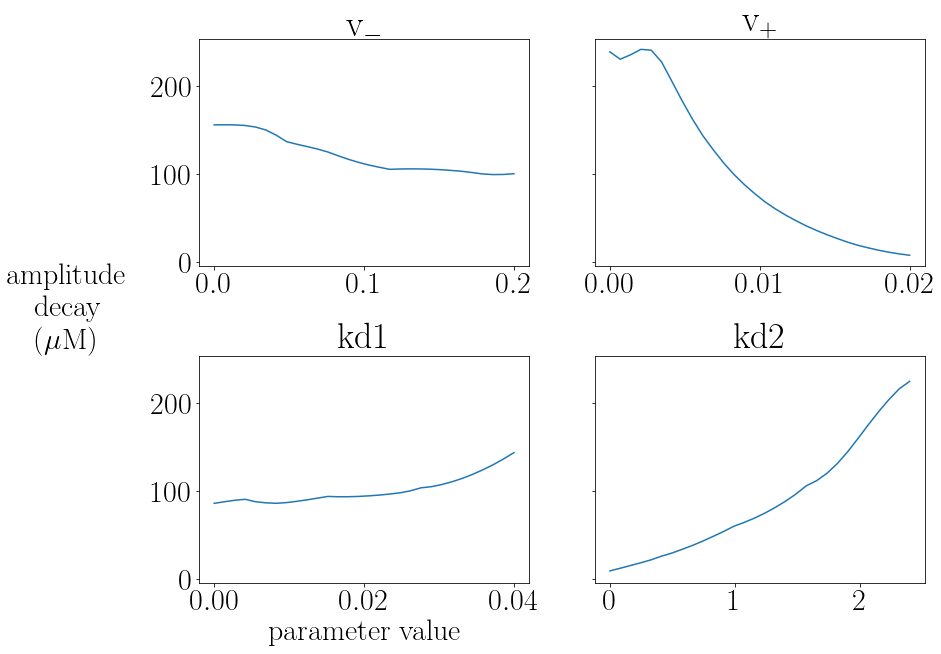

In [10]:
variables = ['v_3k', 'v_delta', 'kd1', 'kd2']
labels = ['v$_-$', 'v$_+$', 'kd1', 'kd2']
decays = pickle.load(open('data/plot_data/falloff/2.1_oscillation_var', 'rb'))
ranges = [np.linspace(0, 0.2, 30),
np.linspace(0, 0.02, 30),
np.linspace(0, 0.04, 30),
np.linspace(0, 2.4, 30)]

fig, ax = plt.subplots(2, 2, figsize=(13, 10), sharey=True)

plt.subplots_adjust(hspace=0.4)

for i, var in enumerate(variables):
    x = i // 2
    y = i % 2
    
    rnge = ranges[i]
    plot_x = []
    
    plot_decays = -pd.Series(decays[var]).ewm(5).mean()
    ax[x, y].plot(rnge, plot_decays* 1000)
    ax[x, y].set_title(labels[i])
    
ax[1, 0].set_xlabel('parameter value')
ax[1, 0].set_ylabel('amplitude \n decay \n ($\mu$M)', rotation=0, labelpad=80)

# plt.tight_layout()
ax[1, 0].yaxis.set_label_coords(-0.4, 1)
plt.savefig('figures/paper_plots/falloff/2_1_var_falloffs', bbox_inches='tight')

### Visual comparison

We perform a similar experiment as the previous section where we adjust either
1. ER depletion rate by artificially smoothing and stretching the ER transient generated from the control experiment.
2. The Gd2 strength through the kd2 parameter

**Gd2 Strength**

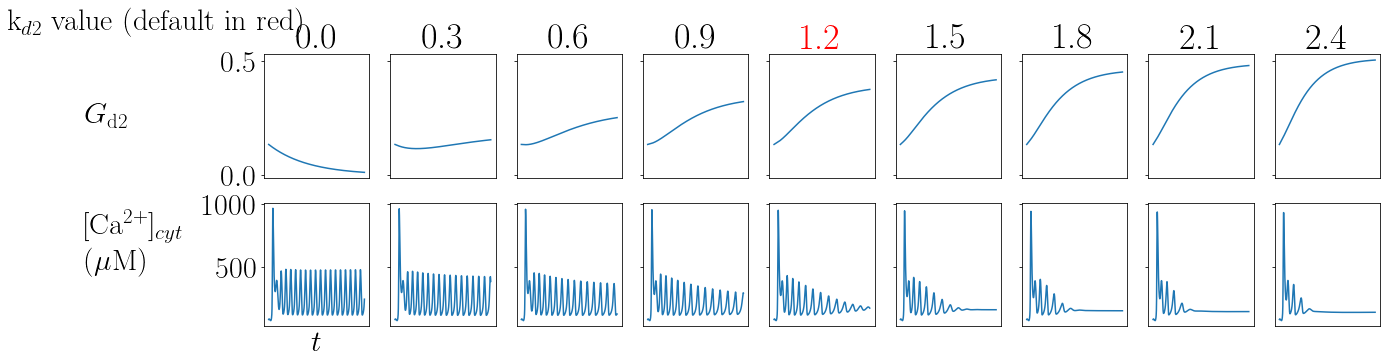

In [8]:
cfg.input_start = 10
cfg.input_max = 0.08
cfg.input_duration = 500
cfg.v_delta = 0.005

set_init('poisson')
# run_experiment('pulse', t_f=250, max_step=0.5)
# fix_c_er = cfg.c_er

fig, ax = plt.subplots(2, 9, figsize=(20, 5), sharey='row', sharex=True)

for i, mult in enumerate(np.linspace(0, 2.4, 9)):
    # print(mult)
    # inter = scipy.interpolate.interp1d(cfg.t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
    cfg.kd2 = mult
    run_experiment('pulse', t_f=490, max_step=0.5)
    plot_experiment_plots(['Gd2', 'c'], axs=ax[:, i], add_ylabels=(i == 0), add_xlabel=(i==0), ylabel_padding=[-1.7, 0.4],
                         plot_input=False)
    c = 'red' if mult == 1.2 else 'black'
    ax[0, i].set_title(mult, color=c)

    ax[0, i].set_title(round(mult, 3))

plt.text(0.05, 0.95, 'k$_{d2}$ value (default in red)', transform=plt.gcf().transFigure, ha='center', fontsize=30)
# plot_experiment_plots(['glut', 'c_er', 'c'])
cfg.kd2 = 1.2

plt.savefig(falloff_fig_folder + '2_2_1_kd2_examples.png', bbox_inches='tight')



**ER Drain Rate**

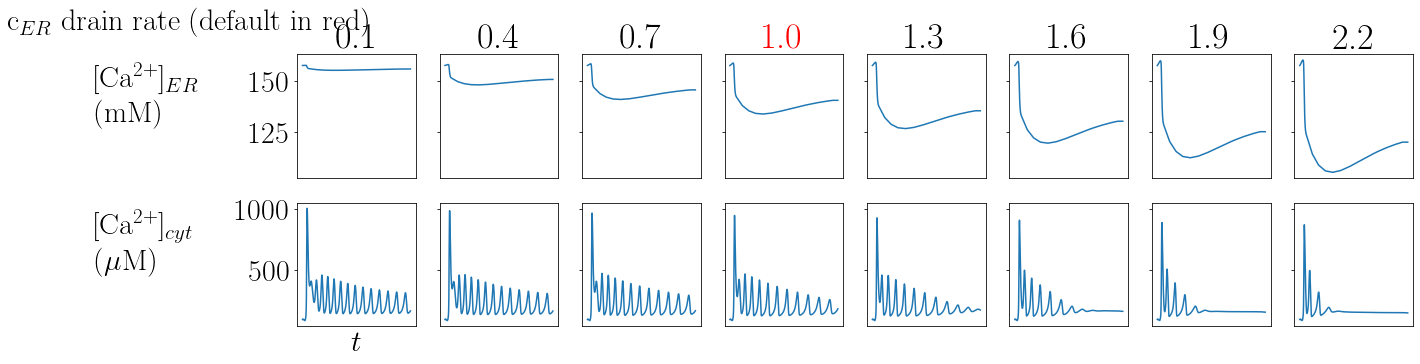

In [9]:
cfg.input_start = 10
cfg.input_max = 0.08
cfg.input_duration = 500
cfg.v_delta = 0.005
cfg.kd2 = 1.2
set_init('poisson')
run_experiment('pulse', t_f=490, max_step=0.5)
fix_c_er = cfg.c_er

fig, ax = plt.subplots(2, 8, figsize=(20, 5), sharey='row', sharex=True)

peaks = scipy.signal.find_peaks(cfg.c_er)[0]
fix_c_er = np.append(cfg.c_er[:peaks[1]-50], cfg.c_er[peaks[1:]])
fix_c_er = np.append(fix_c_er, fix_c_er[-1])
fix_t = np.append(cfg.t[:peaks[1]-50], cfg.t[peaks[1:]])
fix_t = np.append(fix_t, 2000)
for i, mult in enumerate([0.1, 0.4, 0.7, 1.0, 1.3, 1.6, 1.9, 2.2]):
    # print(mult)
    inter = scipy.interpolate.interp1d(fix_t, fix_c_er * mult + (fix_c_er[0] * (1-mult)))
    run_experiment('pulse', t_f=500, max_step=0.5, fix_c_er_func=inter)
    plot_experiment_plots(['c_er', 'c'], axs=ax[:, i], add_ylabels=(i == 0), add_xlabel=(i==0), ylabel_padding=[-1.7, 0.4],
                         plot_input=False)
    c = 'red' if mult == 1.0 else 'black'
    ax[0, i].set_title(mult, color=c)

plt.text(0.05, 0.95, 'c$_{ER}$ drain rate (default in red)', transform=plt.gcf().transFigure, ha='center', fontsize=30)
# plot_experiment_plots(['glut', 'c_er', 'c'])

plt.savefig(falloff_fig_folder + '2_2_1_c_er_examples.png', bbox_inches='tight')

**Turning off ER depletion, Gd2, or both**

From this graph alone, we can see that amplitude adaptation does not significantly occur without Gd2 causing gradual desensitization of the GPCR. The reverse is not true - even while perpetually refilling ER storage, adaptation can still occur.

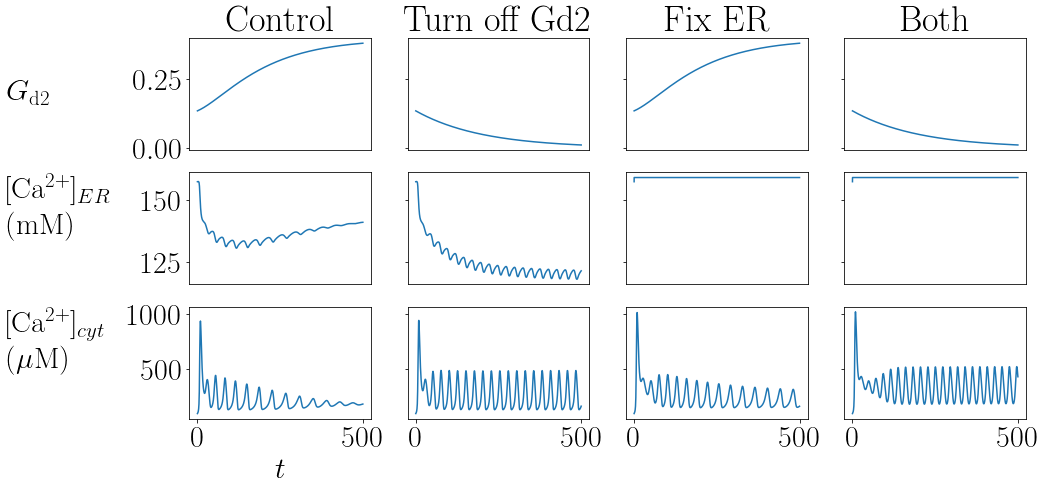

In [50]:
def run_conditional(conds=['kd2_off', 'drain_off']):
    '''
    conds: select options to run experiment with
    '''
    cfg.kd1 = 0.02
    cfg.v_delta = 0.005
    cfg.v_3k = 0.1
    # cfg.input_max = 0.08
    set_init('poisson')
    if 'kd2_off' in conds:
        cfg.kd2 = 0
    else:
        cfg.kd2 = 1.2
        # cfg.kd2 = 0.6
    # print(cfg.kd2)
        
    fix_c_er_val = 159.142628
    if 'drain_off' in conds:
        run_experiment('pulse', t_f=500, max_step=0.5, fix_c_er=fix_c_er_val)
    else:
        run_experiment('pulse', t_f=500, max_step=0.5)
        
        
def get_peaks(t, c):
    '''
    Get peaks for an oscillation
    '''
    peaks = scipy.signal.find_peaks(c)[0]
    return_low_lim = 250 #how far does calcium have to return before we consider
                         #ourselves to be in standard oscillation range
    first_peak = peaks[0]
    return_low = np.argmax(c[first_peak:] < return_low_lim)
    if return_low == 0:
        osc_start = -1
    else:
        osc_start = first_peak + return_low
    peaks = np.append([first_peak], scipy.signal.find_peaks(c[osc_start:])[0] + osc_start)
    c_peaks = c[peaks]
    t_peaks = t[peaks]
    return t_peaks, c_peaks




condss = [['control'], ['kd2_off'], ['drain_off'], ['kd2_off', 'drain_off']]
labels = ['Control', 'Turn off Gd2', 'Fix ER', 'Both']
fig, ax = plt.subplots(3, 4, figsize=(15, 7), sharey='row')
cfg.input_max = 0.08
for i, conds in enumerate(condss):
    run_conditional(conds)
    plot_experiment_plots(['Gd2', 'c_er', 'c'], axs=ax[:, i], legend_label=labels[i], ylabel_padding=[-1, 0.4],
                     add_ylabels=(i == 0), add_xlabel=(i==0), plot_input=False)
    ax[0, i].set_title(labels[i])

plt.savefig(falloff_fig_folder + '2.2.2_condition_examples.png', bbox_inches='tight')

### Summary of amplitude decay

The same as above can be seen here, where amplitude decay falls off completely as Gd2 weakens, but not as calcium weakens.

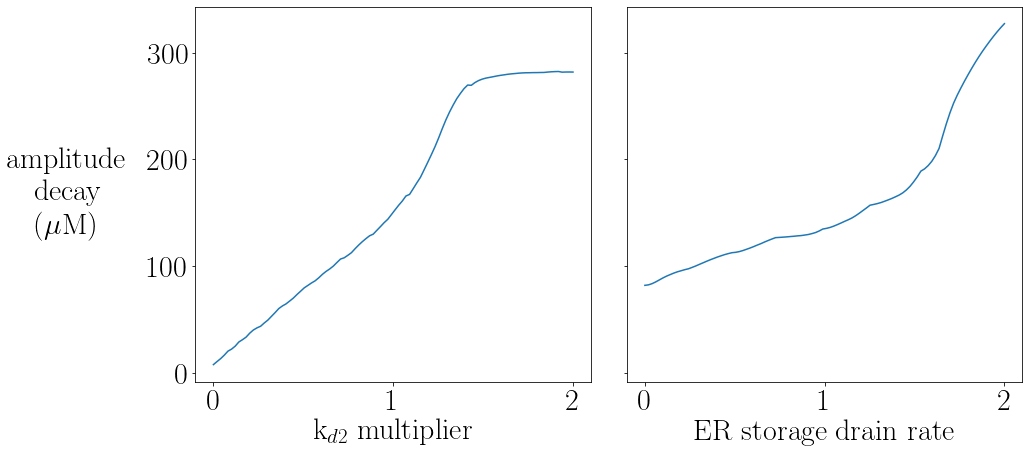

In [3]:
all_t_peaks, all_c_peaks, multipliers, decays = \
    pickle.load(open('data/plot_data/oscillation_falloff_er_kd2', 'rb'))

amp_changes = []
isi_changes = []
plot_x = []
var = 'kd2'
for j in range(len(multipliers)):
    if len(all_c_peaks[var][j]) > 4:
        # first_c_peak = all_c_peaks[var][j][1]
        first_c_peak = np.max(all_c_peaks[var][j][1:])
        last_c_peaks = all_c_peaks[var][j][-2]
        last_c_peak = np.mean(last_c_peaks)
        
        amp_changes.append( last_c_peak - first_c_peak )

        first_isi = all_t_peaks[var][j][2] - all_t_peaks[var][j][1]
        last_isi = all_t_peaks[var][j][-1] - all_t_peaks[var][j][-2]
        isi_changes.append( last_isi - first_isi )

        plot_x.append(multipliers[j])

# ax[x, y].plot(plot_x, isi_changes)
# ax[x, y].set_title(labels[i])

fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
# ax[0].plot(np.array(plot_x) * 1.2, -np.array(amp_changes))
ax[0].plot(np.array(plot_x), -np.array(decays[var]) * 1000)
ax[0].set_ylabel('amplitude \n decay \n ($\mu$M)', rotation=0, labelpad=80, va='center')
ax[0].set_xlabel('k$_{d2}$ multiplier')

amp_changes = []
isi_changes = []
plot_x = []
var = 'er_depletion'
for j in range(len(multipliers)):
    if len(all_c_peaks[var][j]) > 4:
        # first_c_peak = all_c_peaks[var][j][1]
        first_c_peak = np.max(all_c_peaks[var][j][1:])
        last_c_peaks = all_c_peaks[var][j][-2]
        last_c_peak = np.mean(last_c_peaks)
        amp_changes.append( last_c_peak - first_c_peak )

        first_isi = all_t_peaks[var][j][2] - all_t_peaks[var][j][1]
        last_isi = all_t_peaks[var][j][-1] - all_t_peaks[var][j][-2]
        isi_changes.append( last_isi - first_isi )

        plot_x.append(multipliers[j])
        
# ax[1].plot(plot_x, -np.array(amp_changes))
ax[1].plot(plot_x, -pd.Series(decays[var]).ewm(5).mean() * 1000)
ax[1].set_xlabel('ER storage drain rate')


plt.tight_layout()
plt.savefig('figures/paper_plots/falloff/2_2_1_kd2_er_oscillation_amplitude.png', bbox_inches='tight')


## Conclusions

Short-term calcium response adaptation is driven by both ER depletion and Gd1 desensitization.

Long-term oscillation amplitude adaptation is driven primarily by Gd2 desensitization

# Spritz Experiments

In this section, we explore the effects of various parameters on spritz experiments. (Here maybe we should explore the effects of channel blocking and parameters as before)

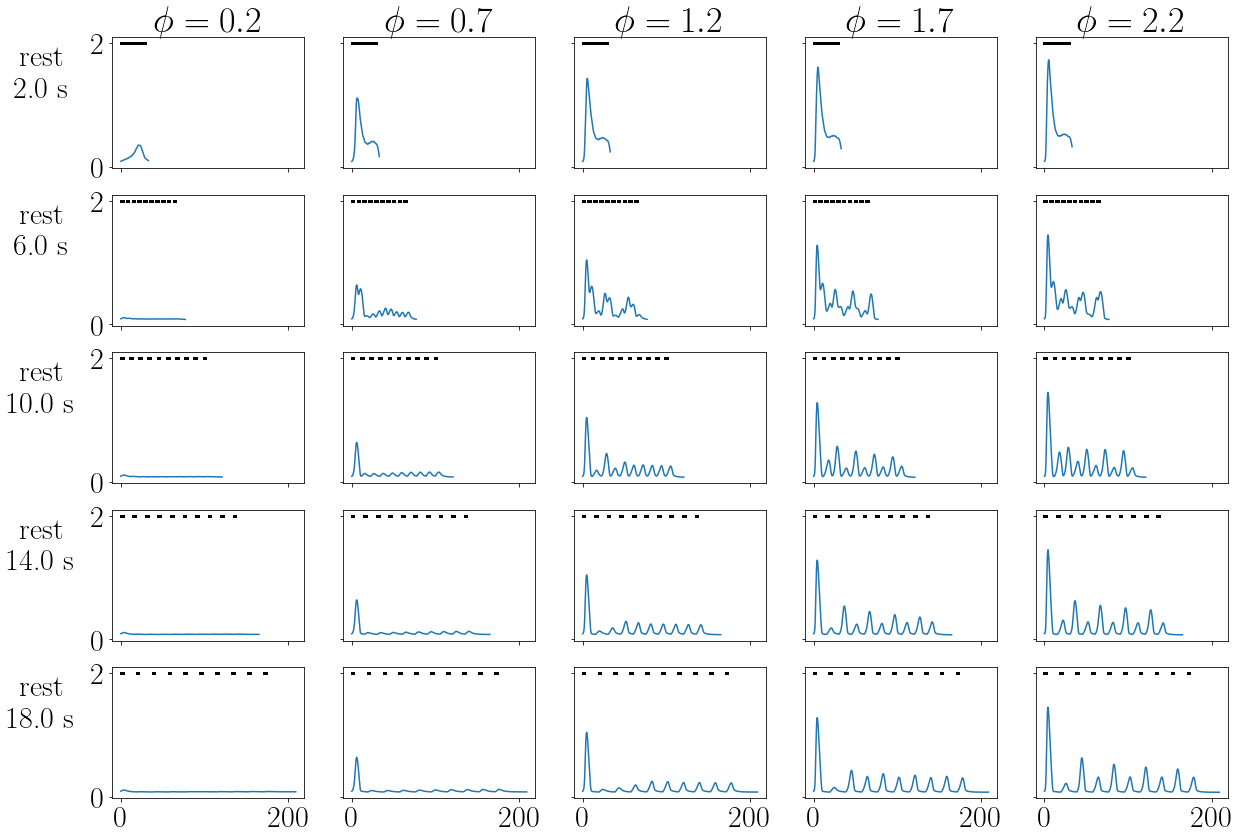

In [17]:
# Older code

periods = np.arange(2, 2.1+4*5, 4)
gluts = np.arange(0.2, 0.3+0.5*5, 0.5)
fig, ax = plt.subplots(5, 5, figsize=(20, 14), sharex=True, sharey=True)
set_init('poisson')
for i in range(5):
    ax[i, 0].set_ylabel('rest \n ' + str(periods[i]) + ' s', rotation=0, labelpad=50)
    ax[0, i].set_title('$\phi=' + str(round(gluts[i], 1)) + '$')
    for j in range(5):
        period = periods[i]
        glut = gluts[j]
        run_spritz(period=period, conc=glut, dur=1)
        
        ax[i, j].plot(cfg.t, cfg.c)
        spikes = np.array([(cfg.oscillation_on_duration + cfg.oscillation_off_duration)*t for t in range(cfg.num_oscillations)])
        
        for k in range(cfg.num_oscillations):
            ax[i, j].plot([spikes[k], spikes[k] + cfg.oscillation_on_duration + 1], [2, 2], c='k', linewidth=3)

plt.savefig(spritz_fig_folder + '1_spritz_responses.png', bbox_inches='tight')

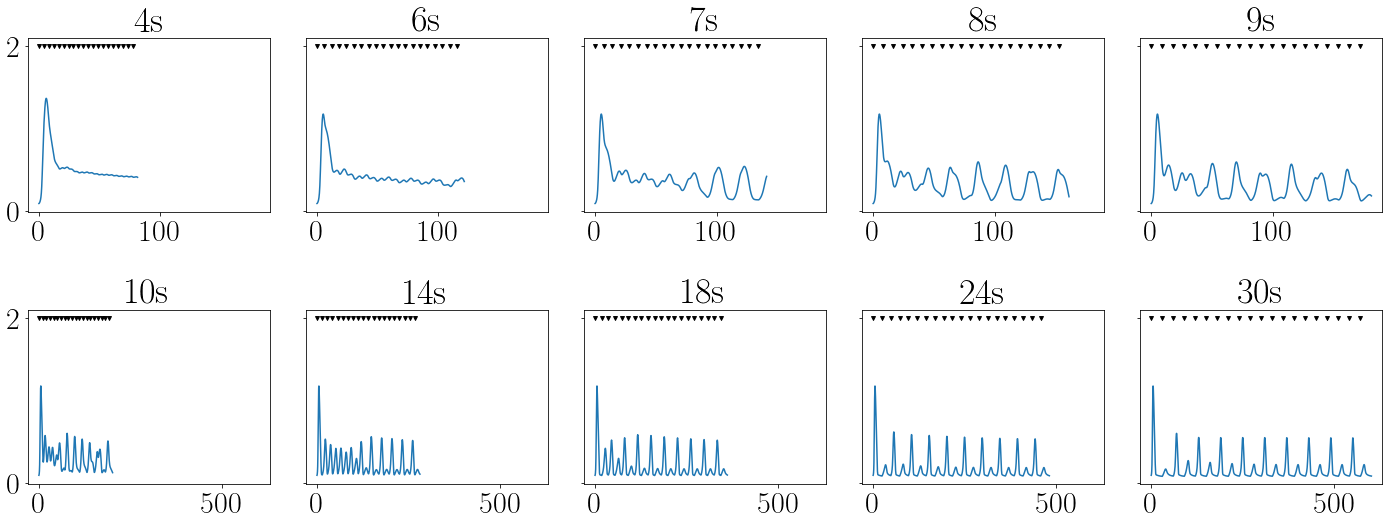

In [3]:
cfg.km = 0.2
num_exps = 10
rest_increase = 2
glut = 500
num_spikes = 20
# rests = np.arange(2, 2+rest_increase*num_exps, rest_increase)
rests = [4, 6, 7, 8, 9, 10, 14, 18, 24, 30]
fig, ax = plt.subplots(2, 5, figsize=(20, 8), sharex='row', sharey=True)
set_init('poisson')
for i, rest in enumerate(rests):
    x = i // 5
    y = i % 5
    
    ax[x, y].set_title(f'{rest}s')
    run_spritz(period=rest, conc=glut, dur=0.06, num=num_spikes)

    ax[x, y].plot(cfg.t, cfg.c)
    spikes = np.array([(cfg.oscillation_on_duration + cfg.oscillation_off_duration)*t for t in range(cfg.num_oscillations)])
    ax[x, y].scatter(spikes.copy(), np.full(len(spikes), 2), marker='v', color='black', s=15)

plt.tight_layout()
plt.savefig(spritz_fig_folder + '1_spritz_responses.png', bbox_inches='tight')

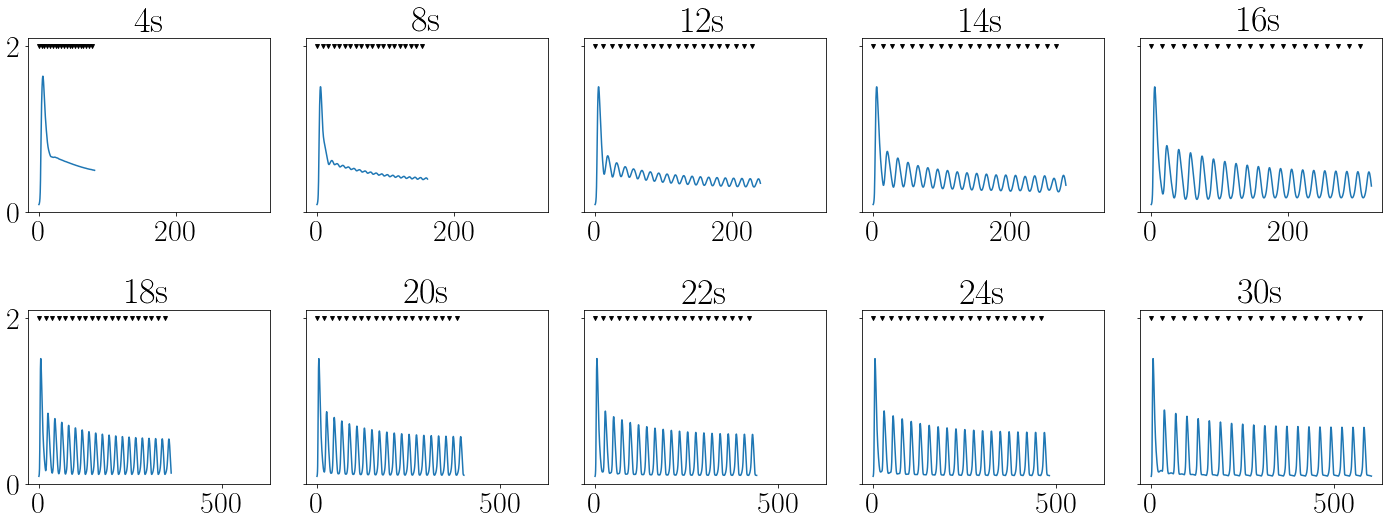

In [5]:
cfg.km = 0.04
num_exps = 10
rest_increase = 2
glut = 500
num_spikes = 20

# rests = np.arange(2, 2+rest_increase*num_exps, rest_increase)
rests = [4, 8, 12, 14, 16, 18, 20, 22, 24, 30]
fig, ax = plt.subplots(2, 5, figsize=(20, 8), sharex='row', sharey=True)
set_init('poisson')
for i, rest in enumerate(rests):
    x = i // 5
    y = i % 5
    
    ax[x, y].set_title(f'{rest}s')
    run_spritz(period=rest, conc=glut, dur=0.06, num=num_spikes)

    ax[x, y].plot(cfg.t, cfg.c)
    spikes = np.array([(cfg.oscillation_on_duration + cfg.oscillation_off_duration)*t for t in range(cfg.num_oscillations)])
    ax[x, y].scatter(spikes.copy(), np.full(len(spikes), 2), marker='v', color='black', s=15)

plt.tight_layout()
plt.savefig(spritz_fig_folder + '1_spritz_responses_km0_04.png', bbox_inches='tight')